# EDA 코드 링크
- 공통으로 기본적인 데이터 탐색, 인원, 요일별 EDA가 들어있을 수 있습니다.
- 메뉴범주화(재료별) https://github.com/stonesteel0606/Prediction-of-the-number-of-people-eating-in-the-cafeteria/blob/main/Main_menu_feature_add.ipynb
- 메뉴범주화(국가별) : https://github.com/JounKK/AIS8_task/blob/main/Mid2/mid_2_EDA.ipynb
- 메뉴범주화(조리방법별) https://github.com/2mook2/AIS8/blob/main/MID2/mid2_eda.ipynb
- 반찬갯수 : https://github.com/MoonsRainbow/MS_AIS8_Project/blob/master/Mid_Project_02/menu_count.ipynb
- 인원수 스케일링 : https://github.com/MoonsRainbow/MS_AIS8_Project/blob/master/Mid_Project_02/headcount_scaling.ipynb
- 날씨 : https://github.com/hapvpy/MID-PROJECT-2/blob/main/train_weather.ipynb
- 공휴일 관련 : https://github.com/stbpie/project/blob/master/EDA_JW.ipynb


**EDA를 통해서 필요 피처를 선정하였고, 선정된 피처를 merge하여 최종 데이터셋으로 사용하였습니다.**

# 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

import catboost

# 데이터셋 로드

In [2]:
base_path = "data/구내식당"

train_lunch = pd.read_csv('https://raw.githubusercontent.com/JounKK/AIS8_task/main/Mid2/merged_train_lunch.csv')
train_dinner = pd.read_csv('https://raw.githubusercontent.com/JounKK/AIS8_task/main/Mid2/merged_train_dinner.csv')
test_lunch = pd.read_csv('https://raw.githubusercontent.com/JounKK/AIS8_task/main/Mid2/merged_test_lunch.csv')
test_dinner = pd.read_csv('https://raw.githubusercontent.com/JounKK/AIS8_task/main/Mid2/merged_test_dinner.csv')
submission = pd.read_csv(f'{base_path}/sample_submission.csv')

train_lunch.shape, train_dinner.shape, test_lunch.shape, test_dinner.shape, submission.shape

((1205, 24), (1161, 24), (50, 23), (50, 23), (50, 3))

# 데이터셋 확인

In [3]:
display(train_lunch.head(2))
train_lunch.info()

,휴가자수,공휴일후,식사가능인원,요일넘버,출장자수,월,공휴일전,정원수,연차쓰기좋은날,야근수,...,재택근무자수,국,중식계,메인메뉴범주_조림,메인메뉴범주_찜,메인메뉴범주_샐러드,메인메뉴범주_국물,메인메뉴범주_튀김,메인메뉴범주_볶음,메인메뉴범주_구이
0,50,0,2401.0,0,150,2,0,2601,0,238,...,0,5,1039,0,0,0,0,0,1,0
1,50,0,2378.0,1,173,2,0,2601,0,319,...,0,4,867,0,0,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   휴가자수        1205 non-null   int64  
 1   공휴일후        1205 non-null   int64  
 2   식사가능인원      1205 non-null   float64
 3   요일넘버        1205 non-null   int64  
 4   출장자수        1205 non-null   int64  
 5   월           1205 non-null   int64  
 6   공휴일전        1205 non-null   int64  
 7   정원수         1205 non-null   int64  
 8   연차쓰기좋은날     1205 non-null   int64  
 9   야근수         1205 non-null   int64  
 10  종류          1205 non-null   object 
 11  일           1205 non-null   int64  
 12  반찬1         1205 non-null   int64  
 13  요일          1205 non-null   int64  
 14  재택근무자수      1205 non-null   int64  
 15  국           1205 non-null   int64  
 16  중식계         1205 non-null   int64  
 17  메인메뉴범주_조림   1205 non-null   int64  
 18  메인메뉴범주_찜    1205 non-null   int64  
 19  메인메뉴범주_샐러드  1205 non-null  

In [4]:
display(train_dinner.head(2))
train_dinner.info()

,공휴일후,종류,식사가능인원,출장자수,월,공휴일전,연차쓰기좋은날,일,야근수,휴가자수,...,국,정원수,메인메뉴범주_조림,메인메뉴범주_찜,메인메뉴범주_샐러드,메인메뉴범주_국물,메인메뉴범주_튀김,메인메뉴범주_볶음,연,메인메뉴범주_구이
0,0,한식,2401.0,150,2,0,0,1,238,50,...,3,2601,0,0,0,0,0,0,2016,1
1,0,중식,2378.0,173,2,0,0,2,319,50,...,5,2601,1,0,0,0,0,0,2016,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   공휴일후        1161 non-null   int64  
 1   종류          1161 non-null   object 
 2   식사가능인원      1161 non-null   float64
 3   출장자수        1161 non-null   int64  
 4   월           1161 non-null   int64  
 5   공휴일전        1161 non-null   int64  
 6   연차쓰기좋은날     1161 non-null   int64  
 7   일           1161 non-null   int64  
 8   야근수         1161 non-null   int64  
 9   휴가자수        1161 non-null   int64  
 10  석식계         1161 non-null   int64  
 11  반찬1         1161 non-null   int64  
 12  요일          1161 non-null   int64  
 13  재택근무자수      1161 non-null   int64  
 14  국           1161 non-null   int64  
 15  정원수         1161 non-null   int64  
 16  메인메뉴범주_조림   1161 non-null   int64  
 17  메인메뉴범주_찜    1161 non-null   int64  
 18  메인메뉴범주_샐러드  1161 non-null   int64  
 19  메인메뉴범주_국물   1161 non-null  

In [5]:
display(test_lunch.head(2))
test_lunch.info()

,휴가자수,공휴일후,식사가능인원,요일넘버,출장자수,월,공휴일전,정원수,연차쓰기좋은날,야근수,...,국,메인메뉴범주_조림,메인메뉴범주_샐러드,메인메뉴범주_찜,종류,메인메뉴범주_국물,메인메뉴범주_튀김,메인메뉴범주_구이,메인메뉴범주_볶음,일
0,88,0,2355.0,2,182,1,0,2983,0,5,...,5,0,0,1,한식,0,0,0,0,27
1,104,0,2319.0,3,212,1,0,2983,0,409,...,4,0,0,0,한식,0,0,0,1,28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   휴가자수        50 non-null     int64  
 1   공휴일후        50 non-null     int64  
 2   식사가능인원      50 non-null     float64
 3   요일넘버        50 non-null     int64  
 4   출장자수        50 non-null     int64  
 5   월           50 non-null     int64  
 6   공휴일전        50 non-null     int64  
 7   정원수         50 non-null     int64  
 8   연차쓰기좋은날     50 non-null     int64  
 9   야근수         50 non-null     int64  
 10  반찬1         50 non-null     int64  
 11  요일          50 non-null     int64  
 12  재택근무자수      50 non-null     int64  
 13  국           50 non-null     int64  
 14  메인메뉴범주_조림   50 non-null     int64  
 15  메인메뉴범주_샐러드  50 non-null     int64  
 16  메인메뉴범주_찜    50 non-null     int64  
 17  종류          50 non-null     object 
 18  메인메뉴범주_국물   50 non-null     int64  
 19  메인메뉴범주_튀김   50 non-null     int

In [6]:
display(test_dinner.head(2))
test_dinner.info()

,종류,반찬1,요일,메인메뉴범주_볶음,재택근무자수,공휴일전,정원수,일,공휴일후,휴가자수,...,메인메뉴범주_국물,식사가능인원,메인메뉴범주_튀김,출장자수,월,국,연,연차쓰기좋은날,메인메뉴범주_구이,야근수
0,한식,8,3,1,358,0,2983,27,0,88,...,0,2355.0,0,182,1,4,2021,0,0,5
1,일식,2,4,0,348,0,2983,28,0,104,...,0,2319.0,0,212,1,2,2021,0,0,409


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   종류          48 non-null     object 
 1   반찬1         50 non-null     int64  
 2   요일          50 non-null     int64  
 3   메인메뉴범주_볶음   50 non-null     int64  
 4   재택근무자수      50 non-null     int64  
 5   공휴일전        50 non-null     int64  
 6   정원수         50 non-null     int64  
 7   일           50 non-null     int64  
 8   공휴일후        50 non-null     int64  
 9   휴가자수        50 non-null     int64  
 10  메인메뉴범주_조림   50 non-null     int64  
 11  메인메뉴범주_샐러드  50 non-null     int64  
 12  메인메뉴범주_찜    50 non-null     int64  
 13  메인메뉴범주_국물   50 non-null     int64  
 14  식사가능인원      50 non-null     float64
 15  메인메뉴범주_튀김   50 non-null     int64  
 16  출장자수        50 non-null     int64  
 17  월           50 non-null     int64  
 18  국           50 non-null     int64  
 19  연           50 non-null     int

In [7]:
test_dinner['종류'] = test_dinner['종류'].fillna('한식')

In [8]:
test_dinner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   종류          50 non-null     object 
 1   반찬1         50 non-null     int64  
 2   요일          50 non-null     int64  
 3   메인메뉴범주_볶음   50 non-null     int64  
 4   재택근무자수      50 non-null     int64  
 5   공휴일전        50 non-null     int64  
 6   정원수         50 non-null     int64  
 7   일           50 non-null     int64  
 8   공휴일후        50 non-null     int64  
 9   휴가자수        50 non-null     int64  
 10  메인메뉴범주_조림   50 non-null     int64  
 11  메인메뉴범주_샐러드  50 non-null     int64  
 12  메인메뉴범주_찜    50 non-null     int64  
 13  메인메뉴범주_국물   50 non-null     int64  
 14  식사가능인원      50 non-null     float64
 15  메인메뉴범주_튀김   50 non-null     int64  
 16  출장자수        50 non-null     int64  
 17  월           50 non-null     int64  
 18  국           50 non-null     int64  
 19  연           50 non-null     int

# OneHotEncoding

In [9]:
def ohe(df_train, df_test):
    
    # 원핫인코딩
    col_ohe = df_train.select_dtypes(include="O").columns
    ohe = OneHotEncoder(handle_unknown='ignore')

    X_train_ohe = ohe.fit_transform(df_train[col_ohe])
    X_test_ohe = ohe.transform(df_test[col_ohe])

    # numpy array 로 반환된 값을 pandas DataFrame 형태로 변환해서 데이터를 병합합니다.
    df_train_ohe = pd.DataFrame(X_train_ohe.toarray(), columns=ohe.get_feature_names_out())
    df_train_ohe.index = df_train.index
    print('df_train_ohe :', df_train_ohe.head(2))
    
    # train 데이터를 학습 가능한 형태로 수치데이터와 인코딩한 데이터를 병합하기
    # 기존 train 데이터에서 object 타입의 데이터는 제외하고 가져오기
    X_train_num = df_train.select_dtypes(exclude="object")
    X_train_enc = pd.concat([X_train_num, df_train_ohe], axis=1)
    print(X_train_enc.shape)
   
    # 테스트 데이터 병합
    df_test_ohe = pd.DataFrame(X_test_ohe.toarray(), columns=ohe.get_feature_names_out())
    df_test_ohe.index = df_test.index
    print('df_test_ohe :', df_test_ohe.head(2))
    
    X_test_num = df_test.select_dtypes(exclude="object")
    X_test_enc = pd.concat([X_test_num, df_test_ohe], axis=1)
    print(X_test_enc.shape)
    
    return X_train_enc, X_test_enc

In [10]:
train_lunch_enc, test_lunch_enc = ohe(train_lunch, test_lunch)
train_dinner_enc, test_dinner_enc = ohe(train_dinner, test_dinner)

df_train_ohe :    종류_양식  종류_일식  종류_중식  종류_특식  종류_한식
0    0.0    0.0    0.0    0.0    1.0
1    0.0    0.0    0.0    0.0    1.0
(1205, 28)
df_test_ohe :    종류_양식  종류_일식  종류_중식  종류_특식  종류_한식
0    0.0    0.0    0.0    0.0    1.0
1    0.0    0.0    0.0    0.0    1.0
(50, 27)
df_train_ohe :    종류_양식  종류_일식  종류_중식  종류_한식
0    0.0    0.0    0.0    1.0
1    0.0    0.0    1.0    0.0
(1161, 27)
df_test_ohe :    종류_양식  종류_일식  종류_중식  종류_한식
0    0.0    0.0    0.0    1.0
1    0.0    1.0    0.0    0.0
(50, 26)


In [11]:
# train 원래 1205행 잘 들어왔고, 기존 24열에서 4열(종류 5열-원래'종류') 추가 잘 되었다.
# test도 원래 50행, 정답값 빠져서 27열 잘 됨
train_lunch_enc.shape, test_lunch_enc.shape

((1205, 28), (50, 27))

In [12]:
# 저녁에는 종류가 한개가 적어서 train 27열, test 26열 잘 됨
train_dinner_enc.shape, test_dinner_enc.shape

((1161, 27), (50, 26))

In [13]:
train_lunch_enc.columns

Index(['휴가자수', '공휴일후', '식사가능인원', '요일넘버', '출장자수', '월', '공휴일전', '정원수', '연차쓰기좋은날',
       '야근수', '일', '반찬1', '요일', '재택근무자수', '국', '중식계', '메인메뉴범주_조림', '메인메뉴범주_찜',
       '메인메뉴범주_샐러드', '메인메뉴범주_국물', '메인메뉴범주_튀김', '메인메뉴범주_볶음', '메인메뉴범주_구이',
       '종류_양식', '종류_일식', '종류_중식', '종류_특식', '종류_한식'],
      dtype='object')

In [14]:
train_lunch_enc[["요일","요일넘버"]].head(1)

,요일,요일넘버
0,1,0


# Feature Engineering

## 모두 넣고 돌리기

In [15]:
# # 점심 train, test 데이터
# rf_train_lunch = train_lunch_enc
# rf_test_lunch = test_lunch_enc

# # 저녁 train, test 데이터
# rf_train_dinner = train_dinner_enc
# rf_test_dinner = test_dinner_enc

## 최종 피처 설정

In [16]:
# 점심 train, test 데이터
F_train_lunch = train_lunch[['월', '일', '요일', '공휴일전', '공휴일후', '연차쓰기좋은날', 
                             '식사가능인원', '야근수', '휴가자수', '재택근무자수', '출장자수',
                             '반찬1', '국', '메인메뉴범주_볶음','중식계']]
F_test_lunch = test_lunch[['월', '일', '요일', '공휴일전', '공휴일후', '연차쓰기좋은날', 
                             '식사가능인원', '야근수', '휴가자수', '재택근무자수', '출장자수',
                             '반찬1', '국', '메인메뉴범주_볶음']]

# 저녁 train, test 데이터
F_train_dinner = train_dinner[['월', '일', '요일', '공휴일전', '공휴일후', '연차쓰기좋은날', 
                             '식사가능인원', '야근수', '휴가자수', '재택근무자수', '출장자수',
                             '반찬1', '국', '메인메뉴범주_볶음','석식계']]
F_test_dinner = test_dinner[['월', '일', '요일', '공휴일전', '공휴일후', '연차쓰기좋은날', 
                             '식사가능인원', '야근수', '휴가자수', '재택근무자수', '출장자수',
                             '반찬1', '국', '메인메뉴범주_볶음']]

# train 데이터셋 설정

In [17]:
label_name = '중식계'

X_lunch_train = F_train_lunch.drop(columns=label_name)
y_lunch_train = F_train_lunch[label_name]

print('X :', X_lunch_train.shape, 'y :', y_lunch_train.shape)

X : (1205, 14) y : (1205,)


In [18]:
label_name = '석식계'

X_dinner_train = F_train_dinner.drop(columns=label_name)
y_dinner_train = F_train_dinner[label_name]

print('X :', X_dinner_train.shape, 'y :', y_dinner_train.shape)

X : (1161, 14) y : (1161,)


# Train-Test-Split

## 점심

In [19]:
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_lunch_train, 
                                                            y_lunch_train,
                                                            test_size=0.1, 
                                                            random_state=42)

X_train_l.shape, X_test_l.shape, y_train_l.shape, y_test_l.shape

((1084, 14), (121, 14), (1084,), (121,))

## 저녁

In [20]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_dinner_train, 
                                                            y_dinner_train,
                                                            test_size=0.1, 
                                                            random_state=42)

X_train_d.shape, X_test_d.shape, y_train_d.shape, y_test_d.shape

((1044, 14), (117, 14), (1044,), (117,))

# RandomForest

## Parameter 설정

In [21]:
set_n_estimators = list(range(100, 301, 100)) #
set_max_features = list(range(3, 6, 1))
set_max_depth = list(range(17, 22, 2))
set_min_samples_split = list(range(4, 7, 1)) #2~10
set_min_samples_leaf = list(range(2, 3, 1)) #1~5

params = {'n_estimators': set_n_estimators,
          'max_features': set_max_features,
          'max_depth' : set_max_depth,
          'min_samples_split' : set_min_samples_split,
          'min_samples_leaf' : set_min_samples_leaf
            }

## 모델설정

In [22]:
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_model = RandomForestRegressor(random_state = 42, n_jobs = -1)
grid_l = GridSearchCV(rf_model, param_grid = params, cv = 10, n_jobs = -1, verbose=2)
grid_d = GridSearchCV(rf_model, param_grid = params, cv = 10, n_jobs = -1, verbose=2)

# fit
grid_l.fit(X_train_l, y_train_l)
grid_d.fit(X_train_d, y_train_d)

Fitting 10 folds for each of 81 candidates, totalling 810 fits
Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.9s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   1.3s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=17, max_features=3, min_samples_leaf

GridSearchCV(cv=10, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [17, 19, 21], 'max_features': [3, 4, 5],
                         'min_samples_leaf': [2],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [23]:
# 평가
from sklearn.metrics import mean_absolute_error

print('---------점심---------')
print('최적 하이퍼 파라미터: ', grid_l.best_params_)
y_pred = grid_l.predict(X_test_l)
mae_lunch = mean_absolute_error(y_test_l, y_pred)
print(f'Lunch_MAE: {np.round(mae_lunch,3)}')

print('---------저녁---------')
print('최적 하이퍼 파라미터: ', grid_d.best_params_)
y_pred_dinner = grid_d.predict(X_test_d)
mae_dinner = mean_absolute_error(y_test_d, y_pred_dinner)
print(f'Dinner_MAE: {np.round(mae_dinner,3)}')
# print(f'Lunch_MAE: {np.round(mae,3)}, Dinner_MAE: {np.round(mae_d,3)}', )

---------점심---------
최적 하이퍼 파라미터:  {'max_depth': 21, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Lunch_MAE: 72.193
---------저녁---------
최적 하이퍼 파라미터:  {'max_depth': 17, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}
Dinner_MAE: 45.685


In [24]:
estimator_l = grid_l.best_estimator_
estimator_d = grid_d.best_estimator_

In [25]:
# 전체 데이터로 학습
estimator_l.fit(X_lunch_train, y_lunch_train)
estimator_d.fit(X_dinner_train, y_dinner_train)

RandomForestRegressor(max_depth=17, max_features=5, min_samples_leaf=2,
                      min_samples_split=4, n_jobs=-1, random_state=42)

## 예측

In [26]:
# predict
y_predict_lunch = estimator_l.predict(F_test_lunch)
y_predict_dinner = estimator_d.predict(F_test_dinner)

## 피처 중요도

<AxesSubplot:>

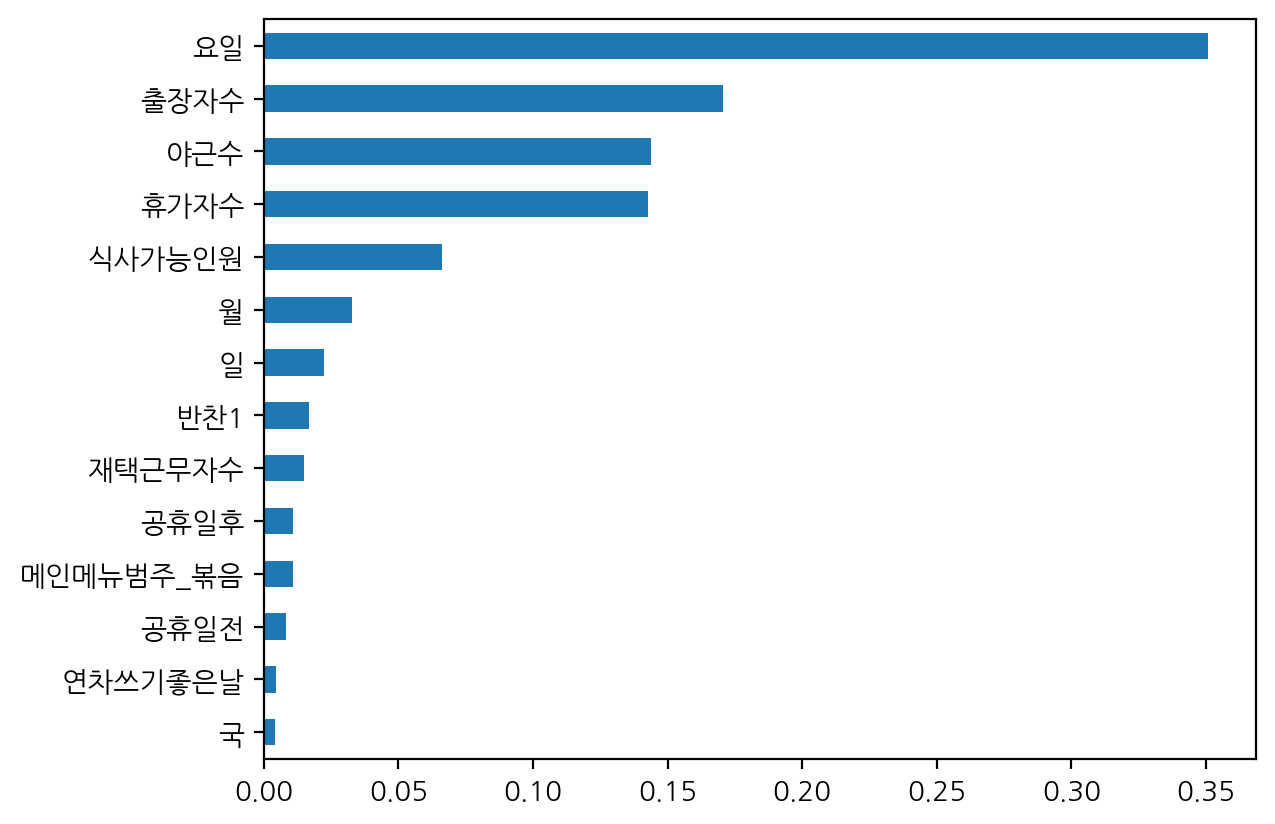

In [27]:
# 피처 중요도 : 점심
fi = pd.Series(estimator_l.feature_importances_)
fi.index = estimator_l.feature_names_in_
fi.sort_values().plot.barh()

<AxesSubplot:>

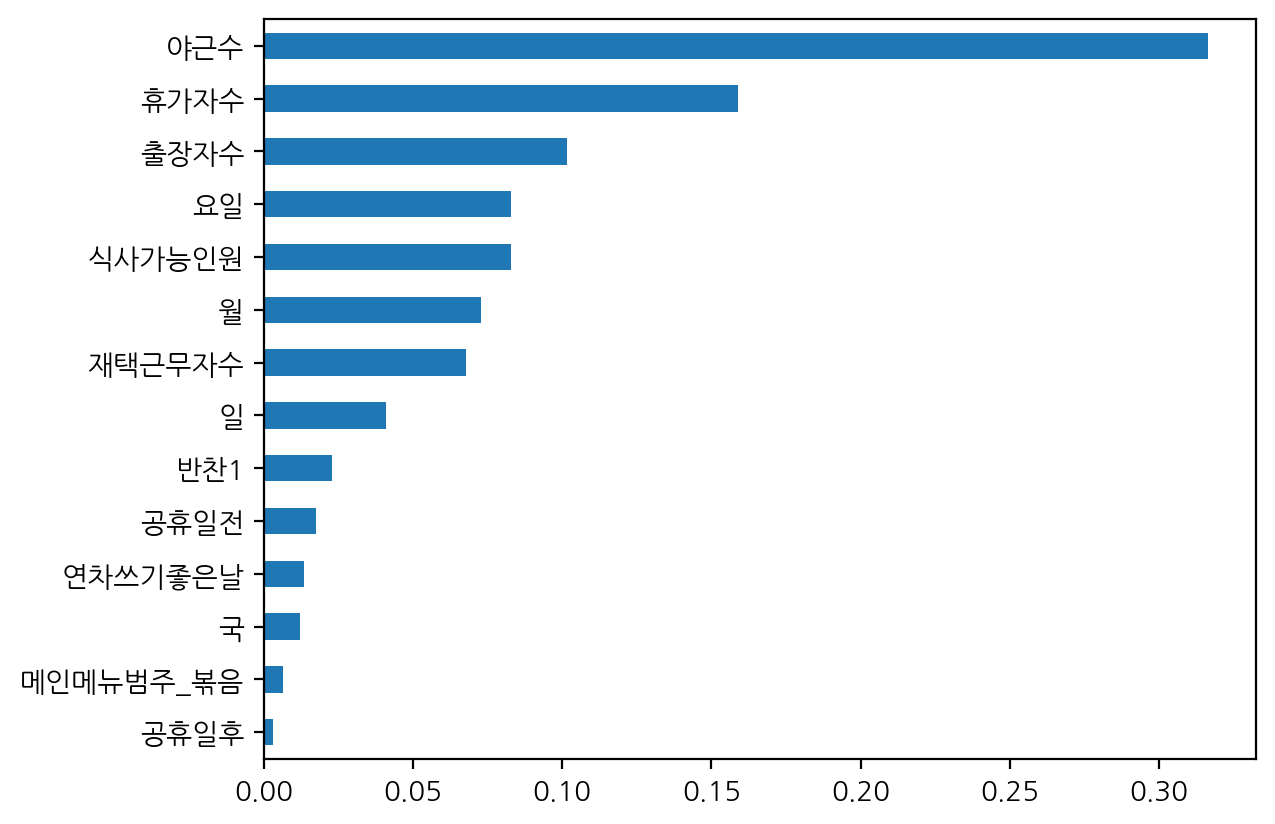

In [28]:
# 피처 중요도 : 저녁
fi = pd.Series(estimator_d.feature_importances_)
fi.index = estimator_d.feature_names_in_
fi.sort_values().plot.barh()

## 답지 작성

In [29]:
# 답안지 양식을 불러옵니다.
submission.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


In [30]:
# 예측한 값을 답안지에 옮겨 적습니다.
submission["중식계"] = y_predict_lunch
submission["석식계"] = y_predict_dinner
submission.head(3)

,일자,중식계,석식계
0,2021-01-27,1002.818237,410.867810
1,2021-01-28,967.377280,436.484333
2,2021-01-29,629.572694,285.386524


## 제출

In [31]:
# 제출하기 위해 csv 파일로 저장합니다.
# test 데이터로 구한 실제 점수를 비교해 보기 위해 제출 시 점수를 함께 적으면 비교하기 좋습니다.
file_name = f"data/구내식당/submit_최종RF_L:{mae_lunch:.5f}, D:{mae_dinner:.5f}.csv"
file_name

'data/구내식당/submit_최종RF_L:72.19324, D:45.68465.csv'

In [32]:
# 제출하기 위해 csv 파일로 저장합니다.
submission.to_csv(file_name, index=False)

In [33]:
# 파일 저장이 제대로 되었는지 확인합니다.
pd.read_csv(file_name)

,일자,중식계,석식계
0,2021-01-27,1002.818237,410.867810
1,2021-01-28,967.377280,436.484333
2,2021-01-29,629.572694,285.386524
3,2021-02-01,1198.848586,521.862643
4,2021-02-02,1011.228274,490.979127
5,2021-02-03,1004.694352,472.704048
6,2021-02-04,973.824376,472.827071
7,2021-02-05,681.541350,393.143672
8,2021-02-08,1277.164223,605.678833
9,2021-02-09,1016.341873,503.180841


#  Catboost + GridSearchCV

## Parameter 설정

In [34]:
set_n_estimators = list(range(250, 610, 20))
print(set_n_estimators)

[250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 510, 530, 550, 570, 590]


In [35]:
set_learning_rate = [lr / 100 for lr in list(range(1, 100, 1))]
print(set_learning_rate)

[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [36]:
param_grid = {
    'n_estimators': set_n_estimators,
    'learning_rate': set_learning_rate,
    'depth': [4, 6, 10]
}

print(param_grid)

{'n_estimators': [250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 470, 490, 510, 530, 550, 570, 590], 'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99], 'depth': [4, 6, 10]}


## lunch model

In [37]:
lunch_model = catboost.CatBoostRegressor(
    eval_metric='MAE',
    random_state=42,
    logging_level='Silent',
    early_stopping_rounds=200,
)

In [38]:
lunch_result = lunch_model.grid_search(
    param_grid=param_grid,
    X=X_train_l,
    y=y_train_l,
    cv=10
)
lunch_result

0:	loss: 111.7777205	best: 111.7777205 (0)	total: 401ms	remaining: 35m 42s
1:	loss: 76.5383919	best: 76.5383919 (1)	total: 673ms	remaining: 29m 57s
2:	loss: 71.0998621	best: 71.0998621 (2)	total: 846ms	remaining: 25m 7s
3:	loss: 69.0798943	best: 69.0798943 (3)	total: 1.05s	remaining: 23m 27s
4:	loss: 67.6896929	best: 67.6896929 (4)	total: 1.25s	remaining: 22m 14s
5:	loss: 67.1837208	best: 67.1837208 (5)	total: 1.46s	remaining: 21m 37s
6:	loss: 65.9914699	best: 65.9914699 (6)	total: 1.63s	remaining: 20m 45s
7:	loss: 67.4349637	best: 65.9914699 (6)	total: 1.81s	remaining: 20m 7s
8:	loss: 66.5206081	best: 65.9914699 (6)	total: 2.03s	remaining: 20m 6s
9:	loss: 67.4880522	best: 65.9914699 (6)	total: 2.25s	remaining: 20m 2s
10:	loss: 67.4231802	best: 65.9914699 (6)	total: 2.44s	remaining: 19m 43s
11:	loss: 67.6189862	best: 65.9914699 (6)	total: 2.63s	remaining: 19m 29s
12:	loss: 66.8355477	best: 65.9914699 (6)	total: 2.81s	remaining: 19m 12s
13:	loss: 67.6509929	best: 65.9914699 (6)	total: 2

112:	loss: 67.6509929	best: 65.9914699 (6)	total: 22s	remaining: 16m 58s
113:	loss: 67.4128344	best: 65.9914699 (6)	total: 22.2s	remaining: 16m 59s
114:	loss: 68.0186180	best: 65.9914699 (6)	total: 22.4s	remaining: 16m 58s
115:	loss: 68.5611156	best: 65.9914699 (6)	total: 22.6s	remaining: 16m 59s
116:	loss: 69.2120559	best: 65.9914699 (6)	total: 22.8s	remaining: 17m
117:	loss: 69.2289072	best: 65.9914699 (6)	total: 23s	remaining: 17m
118:	loss: 67.9487616	best: 65.9914699 (6)	total: 23.3s	remaining: 17m 2s
119:	loss: 69.6257614	best: 65.9914699 (6)	total: 23.5s	remaining: 17m 2s
120:	loss: 69.2746638	best: 65.9914699 (6)	total: 23.7s	remaining: 17m 2s
121:	loss: 67.1382531	best: 65.9914699 (6)	total: 23.9s	remaining: 17m 2s
122:	loss: 68.1208132	best: 65.9914699 (6)	total: 24.1s	remaining: 17m 2s
123:	loss: 67.7957553	best: 65.9914699 (6)	total: 24.3s	remaining: 17m 3s
124:	loss: 68.3430962	best: 65.9914699 (6)	total: 24.5s	remaining: 17m 2s
125:	loss: 68.4359170	best: 65.9914699 (6)	t

223:	loss: 68.3430962	best: 65.9914699 (6)	total: 43.8s	remaining: 16m 41s
224:	loss: 68.4359170	best: 65.9914699 (6)	total: 44s	remaining: 16m 41s
225:	loss: 69.7949591	best: 65.9914699 (6)	total: 44.2s	remaining: 16m 41s
226:	loss: 71.0018807	best: 65.9914699 (6)	total: 44.4s	remaining: 16m 42s
227:	loss: 67.9185979	best: 65.9914699 (6)	total: 44.6s	remaining: 16m 42s
228:	loss: 68.1438578	best: 65.9914699 (6)	total: 44.9s	remaining: 16m 42s
229:	loss: 67.4179762	best: 65.9914699 (6)	total: 45s	remaining: 16m 42s
230:	loss: 68.4248867	best: 65.9914699 (6)	total: 45.2s	remaining: 16m 41s
231:	loss: 68.6093929	best: 65.9914699 (6)	total: 45.5s	remaining: 16m 42s
232:	loss: 69.0009843	best: 65.9914699 (6)	total: 45.7s	remaining: 16m 42s
233:	loss: 71.1803060	best: 65.9914699 (6)	total: 45.9s	remaining: 16m 42s
234:	loss: 68.2274451	best: 65.9914699 (6)	total: 46.1s	remaining: 16m 41s
235:	loss: 68.2412050	best: 65.9914699 (6)	total: 46.3s	remaining: 16m 41s
236:	loss: 66.0358580	best: 6

333:	loss: 68.2274451	best: 65.9914699 (6)	total: 1m 7s	remaining: 16m 45s
334:	loss: 68.2412050	best: 65.9914699 (6)	total: 1m 7s	remaining: 16m 51s
335:	loss: 66.0358580	best: 65.9914699 (6)	total: 1m 8s	remaining: 16m 54s
336:	loss: 69.7530980	best: 65.9914699 (6)	total: 1m 8s	remaining: 16m 55s
337:	loss: 71.2942731	best: 65.9914699 (6)	total: 1m 8s	remaining: 16m 57s
338:	loss: 71.4615797	best: 65.9914699 (6)	total: 1m 8s	remaining: 16m 59s
339:	loss: 71.3112903	best: 65.9914699 (6)	total: 1m 9s	remaining: 17m 1s
340:	loss: 70.3217518	best: 65.9914699 (6)	total: 1m 9s	remaining: 17m 3s
341:	loss: 72.5120405	best: 65.9914699 (6)	total: 1m 10s	remaining: 17m 4s
342:	loss: 71.3534630	best: 65.9914699 (6)	total: 1m 10s	remaining: 17m 6s
343:	loss: 66.6291657	best: 65.9914699 (6)	total: 1m 10s	remaining: 17m 6s
344:	loss: 67.5995669	best: 65.9914699 (6)	total: 1m 10s	remaining: 17m 7s
345:	loss: 68.5360099	best: 65.9914699 (6)	total: 1m 11s	remaining: 17m 7s
346:	loss: 72.0148649	best:

442:	loss: 66.6291657	best: 65.9914699 (6)	total: 1m 43s	remaining: 19m 8s
443:	loss: 67.5995669	best: 65.9914699 (6)	total: 1m 44s	remaining: 19m 8s
444:	loss: 68.5360099	best: 65.9914699 (6)	total: 1m 44s	remaining: 19m 8s
445:	loss: 72.0148649	best: 65.9914699 (6)	total: 1m 44s	remaining: 19m 9s
446:	loss: 71.6467131	best: 65.9914699 (6)	total: 1m 44s	remaining: 19m 9s
447:	loss: 71.3784388	best: 65.9914699 (6)	total: 1m 45s	remaining: 19m 10s
448:	loss: 70.1883076	best: 65.9914699 (6)	total: 1m 45s	remaining: 19m 10s
449:	loss: 69.6913494	best: 65.9914699 (6)	total: 1m 45s	remaining: 19m 10s
450:	loss: 70.6420968	best: 65.9914699 (6)	total: 1m 45s	remaining: 19m 10s
451:	loss: 71.1770991	best: 65.9914699 (6)	total: 1m 46s	remaining: 19m 9s
452:	loss: 71.0409816	best: 65.9914699 (6)	total: 1m 46s	remaining: 19m 9s
453:	loss: 74.1275073	best: 65.9914699 (6)	total: 1m 46s	remaining: 19m 8s
454:	loss: 70.2490857	best: 65.9914699 (6)	total: 1m 46s	remaining: 19m 7s
455:	loss: 69.9033354

552:	loss: 74.1275073	best: 65.9914699 (6)	total: 2m 14s	remaining: 19m 27s
553:	loss: 70.2490857	best: 65.9914699 (6)	total: 2m 14s	remaining: 19m 27s
554:	loss: 69.9033354	best: 65.9914699 (6)	total: 2m 15s	remaining: 19m 28s
555:	loss: 70.8025709	best: 65.9914699 (6)	total: 2m 15s	remaining: 19m 29s
556:	loss: 70.3736066	best: 65.9914699 (6)	total: 2m 16s	remaining: 19m 29s
557:	loss: 73.4930368	best: 65.9914699 (6)	total: 2m 16s	remaining: 19m 29s
558:	loss: 69.5039068	best: 65.9914699 (6)	total: 2m 16s	remaining: 19m 29s
559:	loss: 72.6672759	best: 65.9914699 (6)	total: 2m 16s	remaining: 19m 29s
560:	loss: 72.0102225	best: 65.9914699 (6)	total: 2m 17s	remaining: 19m 29s
561:	loss: 75.3573724	best: 65.9914699 (6)	total: 2m 17s	remaining: 19m 29s
562:	loss: 74.0368512	best: 65.9914699 (6)	total: 2m 17s	remaining: 19m 29s
563:	loss: 73.8990473	best: 65.9914699 (6)	total: 2m 17s	remaining: 19m 28s
564:	loss: 74.3874491	best: 65.9914699 (6)	total: 2m 18s	remaining: 19m 28s
565:	loss: 7

660:	loss: 75.3573724	best: 65.9914699 (6)	total: 2m 45s	remaining: 19m 30s
661:	loss: 74.0368512	best: 65.9914699 (6)	total: 2m 45s	remaining: 19m 29s
662:	loss: 73.8990473	best: 65.9914699 (6)	total: 2m 45s	remaining: 19m 29s
663:	loss: 74.3874491	best: 65.9914699 (6)	total: 2m 45s	remaining: 19m 29s
664:	loss: 73.7035890	best: 65.9914699 (6)	total: 2m 46s	remaining: 19m 29s
665:	loss: 75.3901276	best: 65.9914699 (6)	total: 2m 46s	remaining: 19m 29s
666:	loss: 77.3565259	best: 65.9914699 (6)	total: 2m 46s	remaining: 19m 29s
667:	loss: 78.9699998	best: 65.9914699 (6)	total: 2m 46s	remaining: 19m 28s
668:	loss: 78.3426915	best: 65.9914699 (6)	total: 2m 47s	remaining: 19m 28s
669:	loss: 77.3814612	best: 65.9914699 (6)	total: 2m 47s	remaining: 19m 27s
670:	loss: 77.8552743	best: 65.9914699 (6)	total: 2m 47s	remaining: 19m 27s
671:	loss: 76.2274996	best: 65.9914699 (6)	total: 2m 47s	remaining: 19m 27s
672:	loss: 78.6873002	best: 65.9914699 (6)	total: 2m 48s	remaining: 19m 27s
673:	loss: 7

767:	loss: 78.3426915	best: 65.9890158 (698)	total: 3m 16s	remaining: 19m 33s
768:	loss: 77.3814612	best: 65.9890158 (698)	total: 3m 17s	remaining: 19m 32s
769:	loss: 77.8552743	best: 65.9890158 (698)	total: 3m 17s	remaining: 19m 32s
770:	loss: 76.2274996	best: 65.9890158 (698)	total: 3m 17s	remaining: 19m 33s
771:	loss: 78.6873002	best: 65.9890158 (698)	total: 3m 17s	remaining: 19m 33s
772:	loss: 77.8789246	best: 65.9890158 (698)	total: 3m 18s	remaining: 19m 33s
773:	loss: 76.7783686	best: 65.9890158 (698)	total: 3m 18s	remaining: 19m 34s
774:	loss: 80.1800977	best: 65.9890158 (698)	total: 3m 19s	remaining: 19m 35s
775:	loss: 78.2006381	best: 65.9890158 (698)	total: 3m 19s	remaining: 19m 35s
776:	loss: 80.1892317	best: 65.9890158 (698)	total: 3m 19s	remaining: 19m 35s
777:	loss: 81.9672138	best: 65.9890158 (698)	total: 3m 20s	remaining: 19m 34s
778:	loss: 78.8788944	best: 65.9890158 (698)	total: 3m 20s	remaining: 19m 35s
779:	loss: 81.8442651	best: 65.9890158 (698)	total: 3m 20s	remai

873:	loss: 80.1800977	best: 65.9002764 (797)	total: 3m 51s	remaining: 19m 44s
874:	loss: 78.2006381	best: 65.9002764 (797)	total: 3m 51s	remaining: 19m 44s
875:	loss: 80.1892317	best: 65.9002764 (797)	total: 3m 52s	remaining: 19m 43s
876:	loss: 81.9672138	best: 65.9002764 (797)	total: 3m 52s	remaining: 19m 43s
877:	loss: 78.8788944	best: 65.9002764 (797)	total: 3m 52s	remaining: 19m 43s
878:	loss: 81.8442651	best: 65.9002764 (797)	total: 3m 52s	remaining: 19m 43s
879:	loss: 80.8036398	best: 65.9002764 (797)	total: 3m 53s	remaining: 19m 44s
880:	loss: 81.3531385	best: 65.9002764 (797)	total: 3m 53s	remaining: 19m 43s
881:	loss: 77.3908600	best: 65.9002764 (797)	total: 3m 53s	remaining: 19m 43s
882:	loss: 77.6059619	best: 65.9002764 (797)	total: 3m 54s	remaining: 19m 43s
883:	loss: 79.6751861	best: 65.9002764 (797)	total: 3m 54s	remaining: 19m 42s
884:	loss: 78.8603902	best: 65.9002764 (797)	total: 3m 54s	remaining: 19m 42s
885:	loss: 77.1630696	best: 65.9002764 (797)	total: 3m 54s	remai

979:	loss: 81.3531385	best: 65.9002764 (797)	total: 4m 20s	remaining: 19m 18s
980:	loss: 77.3908600	best: 65.9002764 (797)	total: 4m 20s	remaining: 19m 17s
981:	loss: 77.6059619	best: 65.9002764 (797)	total: 4m 20s	remaining: 19m 16s
982:	loss: 79.6751861	best: 65.9002764 (797)	total: 4m 20s	remaining: 19m 16s
983:	loss: 78.8603902	best: 65.9002764 (797)	total: 4m 20s	remaining: 19m 15s
984:	loss: 77.1630696	best: 65.9002764 (797)	total: 4m 20s	remaining: 19m 14s
985:	loss: 79.1850886	best: 65.9002764 (797)	total: 4m 21s	remaining: 19m 14s
986:	loss: 76.8186000	best: 65.9002764 (797)	total: 4m 21s	remaining: 19m 13s
987:	loss: 79.1352639	best: 65.9002764 (797)	total: 4m 21s	remaining: 19m 12s
988:	loss: 79.3341287	best: 65.9002764 (797)	total: 4m 21s	remaining: 19m 11s
989:	loss: 80.0837712	best: 65.9002764 (797)	total: 4m 21s	remaining: 19m 11s
990:	loss: 78.4388870	best: 65.9002764 (797)	total: 4m 21s	remaining: 19m 11s
991:	loss: 69.7875498	best: 65.9002764 (797)	total: 4m 22s	remai

1084:	loss: 79.1850886	best: 65.9002764 (797)	total: 4m 45s	remaining: 18m 42s
1085:	loss: 76.8186000	best: 65.9002764 (797)	total: 4m 45s	remaining: 18m 41s
1086:	loss: 79.1352639	best: 65.9002764 (797)	total: 4m 46s	remaining: 18m 41s
1087:	loss: 79.3341287	best: 65.9002764 (797)	total: 4m 46s	remaining: 18m 40s
1088:	loss: 80.0837712	best: 65.9002764 (797)	total: 4m 46s	remaining: 18m 40s
1089:	loss: 77.6358069	best: 65.9002764 (797)	total: 4m 46s	remaining: 18m 40s
1090:	loss: 69.5310527	best: 65.9002764 (797)	total: 4m 47s	remaining: 18m 40s
1091:	loss: 67.3744660	best: 65.9002764 (797)	total: 4m 47s	remaining: 18m 40s
1092:	loss: 66.3775390	best: 65.9002764 (797)	total: 4m 48s	remaining: 18m 41s
1093:	loss: 66.1756491	best: 65.9002764 (797)	total: 4m 48s	remaining: 18m 42s
1094:	loss: 65.9002764	best: 65.9002764 (797)	total: 4m 49s	remaining: 18m 43s
1095:	loss: 65.9914699	best: 65.9002764 (797)	total: 4m 49s	remaining: 18m 44s
1096:	loss: 67.1391737	best: 65.9002764 (797)	total:

1119:	loss: 68.1438578	best: 65.9002764 (797)	total: 4m 56s	remaining: 18m 39s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   1.0s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   1.2s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=300; tota

1120:	loss: 67.4179762	best: 65.9002764 (797)	total: 4m 56s	remaining: 18m 38s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.3s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.4s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   1.0s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   1.3s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=300; tota

[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.4s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   1.0s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.8s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   1.6s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.8s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.4s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.4s
[CV] END max_depth=17, max_features=3, min_samples_leaf=2, min_s

[CV] END max_depth=17, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.4s
[CV] END max_depth=17, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.6s
[CV] END max_depth=17, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   1.1s
[CV] END max_depth=17, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   0.9s
[CV] END max_depth=17, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   1.9s
[CV] END max_depth=19, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   1.0s
[CV] END max_depth=19, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.8s
[CV] END max_depth=19, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   1.5s
[CV] END max_depth=19, max_features=3, min_samples_leaf=2, min_s

[CV] END max_depth=21, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.9s
[CV] END max_depth=21, max_features=3, min_samples_leaf=2, min_samples_split=4, n_estimators=300; total time=   1.3s
[CV] END max_depth=21, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=21, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=21, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.5s
[CV] END max_depth=21, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.0s
[CV] END max_depth=21, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.2s
[CV] END max_depth=21, max_features=3, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.7s
[CV] END max_depth=21, max_features=3, min_samples_leaf=2, min_s

[CV] END max_depth=19, max_features=4, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END max_depth=19, max_features=4, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   1.7s
[CV] END max_depth=19, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.6s
[CV] END max_depth=19, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=200; total time=   1.2s
[CV] END max_depth=19, max_features=4, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   1.5s
[CV] END max_depth=19, max_features=5, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.5s
[CV] END max_depth=19, max_features=5, min_samples_leaf=2, min_samples_split=4, n_estimators=100; total time=   0.6s
[CV] END max_depth=19, max_features=5, min_samples_leaf=2, min_samples_split=4, n_estimators=200; total time=   0.9s
[CV] END max_depth=19, max_features=5, min_samples_leaf=2, min_s

1152:	loss: 69.5039068	best: 65.9002764 (797)	total: 5m 4s	remaining: 18m 26s
1153:	loss: 72.6672759	best: 65.9002764 (797)	total: 5m 4s	remaining: 18m 26s
1154:	loss: 72.0102225	best: 65.9002764 (797)	total: 5m 4s	remaining: 18m 25s
1155:	loss: 75.3573724	best: 65.9002764 (797)	total: 5m 5s	remaining: 18m 25s
1156:	loss: 74.0368512	best: 65.9002764 (797)	total: 5m 5s	remaining: 18m 25s
1157:	loss: 73.8990473	best: 65.9002764 (797)	total: 5m 5s	remaining: 18m 24s
1158:	loss: 74.3874491	best: 65.9002764 (797)	total: 5m 5s	remaining: 18m 24s
1159:	loss: 73.7035890	best: 65.9002764 (797)	total: 5m 5s	remaining: 18m 24s
1160:	loss: 75.3901276	best: 65.9002764 (797)	total: 5m 6s	remaining: 18m 23s
1161:	loss: 77.3565259	best: 65.9002764 (797)	total: 5m 6s	remaining: 18m 23s
1162:	loss: 78.9699998	best: 65.9002764 (797)	total: 5m 6s	remaining: 18m 23s
1163:	loss: 78.3426915	best: 65.9002764 (797)	total: 5m 7s	remaining: 18m 22s
1164:	loss: 77.3814612	best: 65.9002764 (797)	total: 5m 7s	remai

1257:	loss: 74.3874491	best: 65.9002764 (797)	total: 5m 34s	remaining: 18m 6s
1258:	loss: 73.7035890	best: 65.9002764 (797)	total: 5m 34s	remaining: 18m 6s
1259:	loss: 75.3901276	best: 65.9002764 (797)	total: 5m 34s	remaining: 18m 6s
1260:	loss: 77.3565259	best: 65.9002764 (797)	total: 5m 35s	remaining: 18m 5s
1261:	loss: 78.9699998	best: 65.9002764 (797)	total: 5m 35s	remaining: 18m 5s
1262:	loss: 78.3426915	best: 65.9002764 (797)	total: 5m 35s	remaining: 18m 5s
1263:	loss: 77.3814612	best: 65.9002764 (797)	total: 5m 35s	remaining: 18m 4s
1264:	loss: 77.8552743	best: 65.9002764 (797)	total: 5m 36s	remaining: 18m 4s
1265:	loss: 76.2274996	best: 65.9002764 (797)	total: 5m 36s	remaining: 18m 4s
1266:	loss: 78.6873002	best: 65.9002764 (797)	total: 5m 36s	remaining: 18m 3s
1267:	loss: 77.8789246	best: 65.9002764 (797)	total: 5m 36s	remaining: 18m 3s
1268:	loss: 76.7783686	best: 65.9002764 (797)	total: 5m 37s	remaining: 18m 2s
1269:	loss: 80.1800977	best: 65.9002764 (797)	total: 5m 37s	rema

1363:	loss: 77.8552743	best: 65.9002764 (797)	total: 6m 8s	remaining: 17m 56s
1364:	loss: 76.2274996	best: 65.9002764 (797)	total: 6m 9s	remaining: 17m 56s
1365:	loss: 78.6873002	best: 65.9002764 (797)	total: 6m 9s	remaining: 17m 56s
1366:	loss: 77.8789246	best: 65.9002764 (797)	total: 6m 9s	remaining: 17m 55s
1367:	loss: 76.7783686	best: 65.9002764 (797)	total: 6m 9s	remaining: 17m 55s
1368:	loss: 80.1800977	best: 65.9002764 (797)	total: 6m 10s	remaining: 17m 55s
1369:	loss: 78.2006381	best: 65.9002764 (797)	total: 6m 10s	remaining: 17m 54s
1370:	loss: 80.1892317	best: 65.9002764 (797)	total: 6m 10s	remaining: 17m 54s
1371:	loss: 81.9672138	best: 65.9002764 (797)	total: 6m 10s	remaining: 17m 54s
1372:	loss: 78.8788944	best: 65.9002764 (797)	total: 6m 11s	remaining: 17m 54s
1373:	loss: 81.8442651	best: 65.9002764 (797)	total: 6m 11s	remaining: 17m 54s
1374:	loss: 80.8036398	best: 65.9002764 (797)	total: 6m 11s	remaining: 17m 53s
1375:	loss: 81.3531385	best: 65.9002764 (797)	total: 6m 1

1468:	loss: 78.2006381	best: 65.9002764 (797)	total: 6m 36s	remaining: 17m 25s
1469:	loss: 80.1892317	best: 65.9002764 (797)	total: 6m 36s	remaining: 17m 25s
1470:	loss: 81.9672138	best: 65.9002764 (797)	total: 6m 36s	remaining: 17m 24s
1471:	loss: 78.8788944	best: 65.9002764 (797)	total: 6m 36s	remaining: 17m 24s
1472:	loss: 81.8442651	best: 65.9002764 (797)	total: 6m 36s	remaining: 17m 23s
1473:	loss: 80.8036398	best: 65.9002764 (797)	total: 6m 37s	remaining: 17m 23s
1474:	loss: 81.3531385	best: 65.9002764 (797)	total: 6m 37s	remaining: 17m 23s
1475:	loss: 77.3908600	best: 65.9002764 (797)	total: 6m 37s	remaining: 17m 23s
1476:	loss: 77.6059619	best: 65.9002764 (797)	total: 6m 37s	remaining: 17m 22s
1477:	loss: 79.6751861	best: 65.9002764 (797)	total: 6m 38s	remaining: 17m 21s
1478:	loss: 78.8603902	best: 65.9002764 (797)	total: 6m 38s	remaining: 17m 21s
1479:	loss: 77.1630696	best: 65.9002764 (797)	total: 6m 38s	remaining: 17m 20s
1480:	loss: 79.1850886	best: 65.9002764 (797)	total:

1572:	loss: 80.8036398	best: 65.8570061 (1489)	total: 7m 4s	remaining: 16m 57s
1573:	loss: 81.3531385	best: 65.8570061 (1489)	total: 7m 4s	remaining: 16m 57s
1574:	loss: 77.3908600	best: 65.8570061 (1489)	total: 7m 4s	remaining: 16m 56s
1575:	loss: 77.6059619	best: 65.8570061 (1489)	total: 7m 4s	remaining: 16m 56s
1576:	loss: 79.6751861	best: 65.8570061 (1489)	total: 7m 4s	remaining: 16m 55s
1577:	loss: 78.8603902	best: 65.8570061 (1489)	total: 7m 5s	remaining: 16m 55s
1578:	loss: 77.1630696	best: 65.8570061 (1489)	total: 7m 5s	remaining: 16m 54s
1579:	loss: 79.1850886	best: 65.8570061 (1489)	total: 7m 5s	remaining: 16m 54s
1580:	loss: 76.8186000	best: 65.8570061 (1489)	total: 7m 5s	remaining: 16m 53s
1581:	loss: 79.1352639	best: 65.8570061 (1489)	total: 7m 5s	remaining: 16m 52s
1582:	loss: 79.3341287	best: 65.8570061 (1489)	total: 7m 5s	remaining: 16m 52s
1583:	loss: 80.0837712	best: 65.8570061 (1489)	total: 7m 6s	remaining: 16m 51s
1584:	loss: 74.4129914	best: 65.8570061 (1489)	total

1675:	loss: 79.6751861	best: 65.8570061 (1489)	total: 7m 28s	remaining: 16m 21s
1676:	loss: 78.8603902	best: 65.8570061 (1489)	total: 7m 28s	remaining: 16m 21s
1677:	loss: 77.1630696	best: 65.8570061 (1489)	total: 7m 28s	remaining: 16m 21s
1678:	loss: 79.1850886	best: 65.8570061 (1489)	total: 7m 28s	remaining: 16m 20s
1679:	loss: 76.8186000	best: 65.8570061 (1489)	total: 7m 29s	remaining: 16m 20s
1680:	loss: 79.1352639	best: 65.8570061 (1489)	total: 7m 29s	remaining: 16m 19s
1681:	loss: 79.3341287	best: 65.8570061 (1489)	total: 7m 29s	remaining: 16m 19s
1682:	loss: 80.0837712	best: 65.8570061 (1489)	total: 7m 29s	remaining: 16m 18s
1683:	loss: 73.9301011	best: 65.8570061 (1489)	total: 7m 30s	remaining: 16m 18s
1684:	loss: 68.3258910	best: 65.8570061 (1489)	total: 7m 30s	remaining: 16m 18s
1685:	loss: 67.2117336	best: 65.8570061 (1489)	total: 7m 30s	remaining: 16m 18s
1686:	loss: 66.2760395	best: 65.8570061 (1489)	total: 7m 31s	remaining: 16m 19s
1687:	loss: 65.8570061	best: 65.8570061 

1779:	loss: 79.1352639	best: 65.8570061 (1489)	total: 7m 54s	remaining: 15m 50s
1780:	loss: 79.3341287	best: 65.8570061 (1489)	total: 7m 54s	remaining: 15m 49s
1781:	loss: 80.0837712	best: 65.8570061 (1489)	total: 7m 54s	remaining: 15m 49s
1782:	loss: 116.3005821	best: 65.8570061 (1489)	total: 7m 54s	remaining: 15m 49s
1783:	loss: 76.7172568	best: 65.8570061 (1489)	total: 7m 55s	remaining: 15m 48s
1784:	loss: 73.1972576	best: 65.8570061 (1489)	total: 7m 55s	remaining: 15m 48s
1785:	loss: 71.5652893	best: 65.8570061 (1489)	total: 7m 55s	remaining: 15m 48s
1786:	loss: 71.2474550	best: 65.8570061 (1489)	total: 7m 56s	remaining: 15m 48s
1787:	loss: 70.0887792	best: 65.8570061 (1489)	total: 7m 56s	remaining: 15m 48s
1788:	loss: 70.9602394	best: 65.8570061 (1489)	total: 7m 56s	remaining: 15m 48s
1789:	loss: 70.5782446	best: 65.8570061 (1489)	total: 7m 57s	remaining: 15m 47s
1790:	loss: 70.8896889	best: 65.8570061 (1489)	total: 7m 57s	remaining: 15m 47s
1791:	loss: 70.1276216	best: 65.8570061

1882:	loss: 75.4333594	best: 65.8570061 (1489)	total: 8m 26s	remaining: 15m 31s
1883:	loss: 72.7126246	best: 65.8570061 (1489)	total: 8m 26s	remaining: 15m 31s
1884:	loss: 71.3632882	best: 65.8570061 (1489)	total: 8m 27s	remaining: 15m 31s
1885:	loss: 71.1634371	best: 65.8570061 (1489)	total: 8m 27s	remaining: 15m 30s
1886:	loss: 70.0309826	best: 65.8570061 (1489)	total: 8m 27s	remaining: 15m 30s
1887:	loss: 70.9149509	best: 65.8570061 (1489)	total: 8m 28s	remaining: 15m 30s
1888:	loss: 70.5782446	best: 65.8570061 (1489)	total: 8m 28s	remaining: 15m 30s
1889:	loss: 70.8896889	best: 65.8570061 (1489)	total: 8m 28s	remaining: 15m 30s
1890:	loss: 69.8830227	best: 65.8570061 (1489)	total: 8m 28s	remaining: 15m 29s
1891:	loss: 72.0052428	best: 65.8570061 (1489)	total: 8m 29s	remaining: 15m 29s
1892:	loss: 72.6886662	best: 65.8570061 (1489)	total: 8m 29s	remaining: 15m 29s
1893:	loss: 74.4418024	best: 65.8570061 (1489)	total: 8m 29s	remaining: 15m 29s
1894:	loss: 73.3417628	best: 65.8570061 

1985:	loss: 70.0309826	best: 65.8570061 (1489)	total: 9m 1s	remaining: 15m 15s
1986:	loss: 70.8175700	best: 65.8570061 (1489)	total: 9m 1s	remaining: 15m 15s
1987:	loss: 70.5782446	best: 65.8570061 (1489)	total: 9m 2s	remaining: 15m 16s
1988:	loss: 70.8896889	best: 65.8570061 (1489)	total: 9m 2s	remaining: 15m 16s
1989:	loss: 69.6603395	best: 65.8570061 (1489)	total: 9m 3s	remaining: 15m 16s
1990:	loss: 72.0052428	best: 65.8570061 (1489)	total: 9m 3s	remaining: 15m 16s
1991:	loss: 72.6886662	best: 65.8570061 (1489)	total: 9m 3s	remaining: 15m 15s
1992:	loss: 74.4418024	best: 65.8570061 (1489)	total: 9m 4s	remaining: 15m 15s
1993:	loss: 73.3417628	best: 65.8570061 (1489)	total: 9m 4s	remaining: 15m 15s
1994:	loss: 73.6336785	best: 65.8570061 (1489)	total: 9m 5s	remaining: 15m 15s
1995:	loss: 72.3167752	best: 65.8570061 (1489)	total: 9m 5s	remaining: 15m 15s
1996:	loss: 72.9212586	best: 65.8570061 (1489)	total: 9m 5s	remaining: 15m 15s
1997:	loss: 70.4747027	best: 65.8570061 (1489)	total

2089:	loss: 72.0052428	best: 65.8570061 (1489)	total: 9m 37s	remaining: 14m 59s
2090:	loss: 72.6886662	best: 65.8570061 (1489)	total: 9m 38s	remaining: 14m 59s
2091:	loss: 74.4418024	best: 65.8570061 (1489)	total: 9m 38s	remaining: 14m 59s
2092:	loss: 73.3417628	best: 65.8570061 (1489)	total: 9m 38s	remaining: 14m 59s
2093:	loss: 73.6336785	best: 65.8570061 (1489)	total: 9m 39s	remaining: 14m 59s
2094:	loss: 72.2549808	best: 65.8570061 (1489)	total: 9m 39s	remaining: 14m 59s
2095:	loss: 72.9212586	best: 65.8570061 (1489)	total: 9m 39s	remaining: 14m 59s
2096:	loss: 70.4747027	best: 65.8570061 (1489)	total: 9m 40s	remaining: 14m 59s
2097:	loss: 74.1740930	best: 65.8570061 (1489)	total: 9m 41s	remaining: 14m 59s
2098:	loss: 74.9049608	best: 65.8570061 (1489)	total: 9m 41s	remaining: 14m 59s
2099:	loss: 73.2876970	best: 65.8570061 (1489)	total: 9m 42s	remaining: 14m 59s
2100:	loss: 72.3121360	best: 65.8570061 (1489)	total: 9m 42s	remaining: 14m 59s
2101:	loss: 71.7682561	best: 65.8570061 

2192:	loss: 73.6336785	best: 65.8570061 (1489)	total: 10m 13s	remaining: 14m 42s
2193:	loss: 72.1291160	best: 65.8570061 (1489)	total: 10m 14s	remaining: 14m 42s
2194:	loss: 72.9212586	best: 65.8570061 (1489)	total: 10m 14s	remaining: 14m 42s
2195:	loss: 70.4747027	best: 65.8570061 (1489)	total: 10m 15s	remaining: 14m 42s
2196:	loss: 74.1740930	best: 65.8570061 (1489)	total: 10m 15s	remaining: 14m 42s
2197:	loss: 74.9049608	best: 65.8570061 (1489)	total: 10m 16s	remaining: 14m 42s
2198:	loss: 73.2876970	best: 65.8570061 (1489)	total: 10m 16s	remaining: 14m 42s
2199:	loss: 72.3121360	best: 65.8570061 (1489)	total: 10m 17s	remaining: 14m 42s
2200:	loss: 71.7682561	best: 65.8570061 (1489)	total: 10m 17s	remaining: 14m 42s
2201:	loss: 71.2085968	best: 65.8570061 (1489)	total: 10m 18s	remaining: 14m 42s
2202:	loss: 72.1650681	best: 65.8570061 (1489)	total: 10m 18s	remaining: 14m 42s
2203:	loss: 75.0848097	best: 65.8570061 (1489)	total: 10m 18s	remaining: 14m 42s
2204:	loss: 74.0186871	best:

2294:	loss: 70.4747027	best: 65.8570061 (1489)	total: 10m 51s	remaining: 14m 26s
2295:	loss: 74.1740930	best: 65.8570061 (1489)	total: 10m 51s	remaining: 14m 26s
2296:	loss: 74.9049608	best: 65.8570061 (1489)	total: 10m 52s	remaining: 14m 25s
2297:	loss: 73.2876970	best: 65.8570061 (1489)	total: 10m 52s	remaining: 14m 25s
2298:	loss: 72.3121360	best: 65.8570061 (1489)	total: 10m 53s	remaining: 14m 25s
2299:	loss: 71.7682561	best: 65.8570061 (1489)	total: 10m 53s	remaining: 14m 25s
2300:	loss: 71.2085968	best: 65.8570061 (1489)	total: 10m 53s	remaining: 14m 25s
2301:	loss: 72.1650681	best: 65.8570061 (1489)	total: 10m 54s	remaining: 14m 25s
2302:	loss: 75.0848097	best: 65.8570061 (1489)	total: 10m 54s	remaining: 14m 25s
2303:	loss: 74.0186871	best: 65.8570061 (1489)	total: 10m 55s	remaining: 14m 25s
2304:	loss: 74.7349022	best: 65.8570061 (1489)	total: 10m 55s	remaining: 14m 25s
2305:	loss: 73.0681522	best: 65.8570061 (1489)	total: 10m 56s	remaining: 14m 25s
2306:	loss: 74.7056781	best:

2396:	loss: 73.2876970	best: 65.8570061 (1489)	total: 11m 29s	remaining: 14m 7s
2397:	loss: 72.3121360	best: 65.8570061 (1489)	total: 11m 29s	remaining: 14m 7s
2398:	loss: 71.7682561	best: 65.8570061 (1489)	total: 11m 30s	remaining: 14m 7s
2399:	loss: 71.2085968	best: 65.8570061 (1489)	total: 11m 30s	remaining: 14m 7s
2400:	loss: 72.1650681	best: 65.8570061 (1489)	total: 11m 30s	remaining: 14m 7s
2401:	loss: 75.0848097	best: 65.8570061 (1489)	total: 11m 31s	remaining: 14m 7s
2402:	loss: 74.0186871	best: 65.8570061 (1489)	total: 11m 31s	remaining: 14m 7s
2403:	loss: 74.7349022	best: 65.8570061 (1489)	total: 11m 31s	remaining: 14m 6s
2404:	loss: 73.0681522	best: 65.8570061 (1489)	total: 11m 32s	remaining: 14m 6s
2405:	loss: 74.7056781	best: 65.8570061 (1489)	total: 11m 32s	remaining: 14m 6s
2406:	loss: 73.6465071	best: 65.8570061 (1489)	total: 11m 33s	remaining: 14m 6s
2407:	loss: 76.2004301	best: 65.8570061 (1489)	total: 11m 33s	remaining: 14m 6s
2408:	loss: 75.3268676	best: 65.8570061 

2498:	loss: 71.2085968	best: 65.8570061 (1489)	total: 12m 7s	remaining: 13m 48s
2499:	loss: 72.1650681	best: 65.8570061 (1489)	total: 12m 7s	remaining: 13m 48s
2500:	loss: 75.0848097	best: 65.8570061 (1489)	total: 12m 7s	remaining: 13m 48s
2501:	loss: 74.0186871	best: 65.8570061 (1489)	total: 12m 8s	remaining: 13m 47s
2502:	loss: 74.7349022	best: 65.8570061 (1489)	total: 12m 8s	remaining: 13m 47s
2503:	loss: 73.0681522	best: 65.8570061 (1489)	total: 12m 9s	remaining: 13m 47s
2504:	loss: 74.7056781	best: 65.8570061 (1489)	total: 12m 9s	remaining: 13m 47s
2505:	loss: 73.6465071	best: 65.8570061 (1489)	total: 12m 9s	remaining: 13m 47s
2506:	loss: 76.2004301	best: 65.8570061 (1489)	total: 12m 10s	remaining: 13m 46s
2507:	loss: 75.3268676	best: 65.8570061 (1489)	total: 12m 10s	remaining: 13m 46s
2508:	loss: 72.0036456	best: 65.8570061 (1489)	total: 12m 10s	remaining: 13m 46s
2509:	loss: 73.1461760	best: 65.8570061 (1489)	total: 12m 11s	remaining: 13m 46s
2510:	loss: 72.5861396	best: 65.8570

2600:	loss: 74.0186871	best: 65.8570061 (1489)	total: 12m 45s	remaining: 13m 27s
2601:	loss: 74.7349022	best: 65.8570061 (1489)	total: 12m 45s	remaining: 13m 27s
2602:	loss: 73.0681522	best: 65.8570061 (1489)	total: 12m 46s	remaining: 13m 27s
2603:	loss: 74.7056781	best: 65.8570061 (1489)	total: 12m 46s	remaining: 13m 27s
2604:	loss: 73.6465071	best: 65.8570061 (1489)	total: 12m 47s	remaining: 13m 27s
2605:	loss: 76.2004301	best: 65.8570061 (1489)	total: 12m 47s	remaining: 13m 27s
2606:	loss: 75.3268676	best: 65.8570061 (1489)	total: 12m 47s	remaining: 13m 26s
2607:	loss: 72.0036456	best: 65.8570061 (1489)	total: 12m 48s	remaining: 13m 26s
2608:	loss: 73.1461760	best: 65.8570061 (1489)	total: 12m 48s	remaining: 13m 26s
2609:	loss: 72.5861396	best: 65.8570061 (1489)	total: 12m 48s	remaining: 13m 25s
2610:	loss: 72.4687061	best: 65.8570061 (1489)	total: 12m 49s	remaining: 13m 25s
2611:	loss: 71.8216739	best: 65.8570061 (1489)	total: 12m 49s	remaining: 13m 25s
2612:	loss: 73.0483989	best:

2702:	loss: 74.7056781	best: 65.8570061 (1489)	total: 13m 24s	remaining: 13m 6s
2703:	loss: 73.6465071	best: 65.8570061 (1489)	total: 13m 25s	remaining: 13m 6s
2704:	loss: 76.2004301	best: 65.8570061 (1489)	total: 13m 25s	remaining: 13m 6s
2705:	loss: 75.3268676	best: 65.8570061 (1489)	total: 13m 25s	remaining: 13m 6s
2706:	loss: 72.0036456	best: 65.8570061 (1489)	total: 13m 26s	remaining: 13m 6s
2707:	loss: 73.1461760	best: 65.8570061 (1489)	total: 13m 26s	remaining: 13m 5s
2708:	loss: 72.5861396	best: 65.8570061 (1489)	total: 13m 26s	remaining: 13m 5s
2709:	loss: 72.4687061	best: 65.8570061 (1489)	total: 13m 27s	remaining: 13m 5s
2710:	loss: 71.8216739	best: 65.8570061 (1489)	total: 13m 27s	remaining: 13m 4s
2711:	loss: 73.0483989	best: 65.8570061 (1489)	total: 13m 27s	remaining: 13m 4s
2712:	loss: 72.0252517	best: 65.8570061 (1489)	total: 13m 28s	remaining: 13m 4s
2713:	loss: 75.3730282	best: 65.8570061 (1489)	total: 13m 28s	remaining: 13m 4s
2714:	loss: 70.2729402	best: 65.8570061 

2804:	loss: 75.3268676	best: 65.8570061 (1489)	total: 14m 2s	remaining: 12m 43s
2805:	loss: 72.0036456	best: 65.8570061 (1489)	total: 14m 2s	remaining: 12m 43s
2806:	loss: 73.1461760	best: 65.8570061 (1489)	total: 14m 3s	remaining: 12m 42s
2807:	loss: 72.5861396	best: 65.8570061 (1489)	total: 14m 3s	remaining: 12m 42s
2808:	loss: 72.4687061	best: 65.8570061 (1489)	total: 14m 3s	remaining: 12m 42s
2809:	loss: 71.8216739	best: 65.8570061 (1489)	total: 14m 4s	remaining: 12m 41s
2810:	loss: 73.0483989	best: 65.8570061 (1489)	total: 14m 4s	remaining: 12m 41s
2811:	loss: 72.0252517	best: 65.8570061 (1489)	total: 14m 4s	remaining: 12m 41s
2812:	loss: 75.3730282	best: 65.8570061 (1489)	total: 14m 5s	remaining: 12m 41s
2813:	loss: 70.2729402	best: 65.8570061 (1489)	total: 14m 5s	remaining: 12m 41s
2814:	loss: 73.2228498	best: 65.8570061 (1489)	total: 14m 6s	remaining: 12m 41s
2815:	loss: 75.2785912	best: 65.8570061 (1489)	total: 14m 6s	remaining: 12m 40s
2816:	loss: 71.5823844	best: 65.8570061 

2906:	loss: 72.5861396	best: 65.8570061 (1489)	total: 14m 42s	remaining: 12m 20s
2907:	loss: 72.4687061	best: 65.8570061 (1489)	total: 14m 43s	remaining: 12m 20s
2908:	loss: 71.8216739	best: 65.8570061 (1489)	total: 14m 43s	remaining: 12m 20s
2909:	loss: 73.0483989	best: 65.8570061 (1489)	total: 14m 43s	remaining: 12m 19s
2910:	loss: 72.0252517	best: 65.8570061 (1489)	total: 14m 44s	remaining: 12m 19s
2911:	loss: 75.3730282	best: 65.8570061 (1489)	total: 14m 44s	remaining: 12m 19s
2912:	loss: 70.2729402	best: 65.8570061 (1489)	total: 14m 45s	remaining: 12m 19s
2913:	loss: 73.2228498	best: 65.8570061 (1489)	total: 14m 45s	remaining: 12m 19s
2914:	loss: 75.2785912	best: 65.8570061 (1489)	total: 14m 45s	remaining: 12m 18s
2915:	loss: 71.5823844	best: 65.8570061 (1489)	total: 14m 46s	remaining: 12m 18s
2916:	loss: 73.8546032	best: 65.8570061 (1489)	total: 14m 46s	remaining: 12m 18s
2917:	loss: 71.9034391	best: 65.8570061 (1489)	total: 14m 47s	remaining: 12m 18s
2918:	loss: 73.6370240	best:

3009:	loss: 72.0252517	best: 65.8570061 (1489)	total: 15m 23s	remaining: 11m 56s
3010:	loss: 75.3730282	best: 65.8570061 (1489)	total: 15m 23s	remaining: 11m 56s
3011:	loss: 70.2729402	best: 65.8570061 (1489)	total: 15m 24s	remaining: 11m 56s
3012:	loss: 73.2228498	best: 65.8570061 (1489)	total: 15m 24s	remaining: 11m 55s
3013:	loss: 75.2785912	best: 65.8570061 (1489)	total: 15m 24s	remaining: 11m 55s
3014:	loss: 71.5823844	best: 65.8570061 (1489)	total: 15m 24s	remaining: 11m 55s
3015:	loss: 73.8546032	best: 65.8570061 (1489)	total: 15m 25s	remaining: 11m 54s
3016:	loss: 71.9034391	best: 65.8570061 (1489)	total: 15m 25s	remaining: 11m 54s
3017:	loss: 73.6370240	best: 65.8570061 (1489)	total: 15m 25s	remaining: 11m 54s
3018:	loss: 73.0254829	best: 65.8570061 (1489)	total: 15m 26s	remaining: 11m 54s
3019:	loss: 74.0750224	best: 65.8570061 (1489)	total: 15m 26s	remaining: 11m 53s
3020:	loss: 74.2455376	best: 65.8570061 (1489)	total: 15m 26s	remaining: 11m 53s
3021:	loss: 76.2132491	best:

3111:	loss: 73.2228498	best: 65.8570061 (1489)	total: 16m 4s	remaining: 11m 32s
3112:	loss: 75.2785912	best: 65.8570061 (1489)	total: 16m 5s	remaining: 11m 32s
3113:	loss: 71.5823844	best: 65.8570061 (1489)	total: 16m 5s	remaining: 11m 32s
3114:	loss: 73.8546032	best: 65.8570061 (1489)	total: 16m 5s	remaining: 11m 31s
3115:	loss: 71.9034391	best: 65.8570061 (1489)	total: 16m 6s	remaining: 11m 31s
3116:	loss: 73.6370240	best: 65.8570061 (1489)	total: 16m 6s	remaining: 11m 31s
3117:	loss: 73.0254829	best: 65.8570061 (1489)	total: 16m 7s	remaining: 11m 30s
3118:	loss: 74.0750224	best: 65.8570061 (1489)	total: 16m 7s	remaining: 11m 30s
3119:	loss: 74.2455376	best: 65.8570061 (1489)	total: 16m 7s	remaining: 11m 30s
3120:	loss: 76.2132491	best: 65.8570061 (1489)	total: 16m 7s	remaining: 11m 30s
3121:	loss: 73.0374655	best: 65.8570061 (1489)	total: 16m 8s	remaining: 11m 29s
3122:	loss: 77.3102411	best: 65.8570061 (1489)	total: 16m 8s	remaining: 11m 29s
3123:	loss: 76.4142826	best: 65.8570061 

3213:	loss: 73.8546032	best: 65.8570061 (1489)	total: 16m 44s	remaining: 11m 6s
3214:	loss: 71.9034391	best: 65.8570061 (1489)	total: 16m 44s	remaining: 11m 5s
3215:	loss: 73.6370240	best: 65.8570061 (1489)	total: 16m 44s	remaining: 11m 5s
3216:	loss: 73.0254829	best: 65.8570061 (1489)	total: 16m 45s	remaining: 11m 5s
3217:	loss: 74.0750224	best: 65.8570061 (1489)	total: 16m 45s	remaining: 11m 5s
3218:	loss: 74.2455376	best: 65.8570061 (1489)	total: 16m 46s	remaining: 11m 4s
3219:	loss: 76.2132491	best: 65.8570061 (1489)	total: 16m 46s	remaining: 11m 4s
3220:	loss: 73.0374655	best: 65.8570061 (1489)	total: 16m 46s	remaining: 11m 4s
3221:	loss: 77.3102411	best: 65.8570061 (1489)	total: 16m 46s	remaining: 11m 3s
3222:	loss: 76.4142826	best: 65.8570061 (1489)	total: 16m 47s	remaining: 11m 3s
3223:	loss: 76.0505992	best: 65.8570061 (1489)	total: 16m 47s	remaining: 11m 3s
3224:	loss: 75.2595003	best: 65.8570061 (1489)	total: 16m 47s	remaining: 11m 2s
3225:	loss: 76.6543059	best: 65.8570061 

3315:	loss: 73.0254829	best: 65.8570061 (1489)	total: 17m 26s	remaining: 10m 40s
3316:	loss: 74.0750224	best: 65.8570061 (1489)	total: 17m 27s	remaining: 10m 40s
3317:	loss: 74.2455376	best: 65.8570061 (1489)	total: 17m 27s	remaining: 10m 40s
3318:	loss: 76.2132491	best: 65.8570061 (1489)	total: 17m 27s	remaining: 10m 40s
3319:	loss: 73.0374655	best: 65.8570061 (1489)	total: 17m 28s	remaining: 10m 39s
3320:	loss: 77.3102411	best: 65.8570061 (1489)	total: 17m 28s	remaining: 10m 39s
3321:	loss: 76.4142826	best: 65.8570061 (1489)	total: 17m 29s	remaining: 10m 39s
3322:	loss: 76.0505992	best: 65.8570061 (1489)	total: 17m 29s	remaining: 10m 38s
3323:	loss: 75.2595003	best: 65.8570061 (1489)	total: 17m 29s	remaining: 10m 38s
3324:	loss: 76.6543059	best: 65.8570061 (1489)	total: 17m 30s	remaining: 10m 38s
3325:	loss: 74.7839468	best: 65.8570061 (1489)	total: 17m 30s	remaining: 10m 38s
3326:	loss: 73.4671773	best: 65.8570061 (1489)	total: 17m 31s	remaining: 10m 37s
3327:	loss: 73.5744942	best:

3417:	loss: 76.2132491	best: 65.8570061 (1489)	total: 18m 8s	remaining: 10m 14s
3418:	loss: 73.0374655	best: 65.8570061 (1489)	total: 18m 8s	remaining: 10m 13s
3419:	loss: 77.3102411	best: 65.8570061 (1489)	total: 18m 9s	remaining: 10m 13s
3420:	loss: 76.4142826	best: 65.8570061 (1489)	total: 18m 9s	remaining: 10m 13s
3421:	loss: 76.0505992	best: 65.8570061 (1489)	total: 18m 10s	remaining: 10m 12s
3422:	loss: 75.2595003	best: 65.8570061 (1489)	total: 18m 10s	remaining: 10m 12s
3423:	loss: 76.6543059	best: 65.8570061 (1489)	total: 18m 10s	remaining: 10m 12s
3424:	loss: 74.7839468	best: 65.8570061 (1489)	total: 18m 11s	remaining: 10m 12s
3425:	loss: 73.4671773	best: 65.8570061 (1489)	total: 18m 11s	remaining: 10m 11s
3426:	loss: 73.5744942	best: 65.8570061 (1489)	total: 18m 12s	remaining: 10m 11s
3427:	loss: 73.5633253	best: 65.8570061 (1489)	total: 18m 12s	remaining: 10m 11s
3428:	loss: 78.9893282	best: 65.8570061 (1489)	total: 18m 12s	remaining: 10m 10s
3429:	loss: 72.2065343	best: 65.

3520:	loss: 76.0505992	best: 65.8570061 (1489)	total: 18m 50s	remaining: 9m 45s
3521:	loss: 75.2595003	best: 65.8570061 (1489)	total: 18m 50s	remaining: 9m 45s
3522:	loss: 76.6543059	best: 65.8570061 (1489)	total: 18m 51s	remaining: 9m 45s
3523:	loss: 74.7839468	best: 65.8570061 (1489)	total: 18m 51s	remaining: 9m 45s
3524:	loss: 73.4671773	best: 65.8570061 (1489)	total: 18m 51s	remaining: 9m 44s
3525:	loss: 73.5744942	best: 65.8570061 (1489)	total: 18m 52s	remaining: 9m 44s
3526:	loss: 73.5633253	best: 65.8570061 (1489)	total: 18m 52s	remaining: 9m 44s
3527:	loss: 78.9893282	best: 65.8570061 (1489)	total: 18m 52s	remaining: 9m 43s
3528:	loss: 72.2065343	best: 65.8570061 (1489)	total: 18m 53s	remaining: 9m 43s
3529:	loss: 77.5514189	best: 65.8570061 (1489)	total: 18m 53s	remaining: 9m 43s
3530:	loss: 78.2694331	best: 65.8570061 (1489)	total: 18m 53s	remaining: 9m 42s
3531:	loss: 76.8501507	best: 65.8570061 (1489)	total: 18m 54s	remaining: 9m 42s
3532:	loss: 77.2564913	best: 65.8570061 

3623:	loss: 93.7206993	best: 65.8570061 (1489)	total: 20m 42s	remaining: 9m 50s
3624:	loss: 94.3054783	best: 65.8570061 (1489)	total: 20m 43s	remaining: 9m 50s
3625:	loss: 93.9325293	best: 65.8570061 (1489)	total: 20m 45s	remaining: 9m 50s
3626:	loss: 103.1708859	best: 65.8570061 (1489)	total: 20m 47s	remaining: 9m 51s
3627:	loss: 102.3623998	best: 65.8570061 (1489)	total: 20m 48s	remaining: 9m 51s
3628:	loss: 99.2827362	best: 65.8570061 (1489)	total: 20m 50s	remaining: 9m 51s
3629:	loss: 95.4394382	best: 65.8570061 (1489)	total: 20m 51s	remaining: 9m 51s
3630:	loss: 100.5038893	best: 65.8570061 (1489)	total: 20m 53s	remaining: 9m 51s
3631:	loss: 102.0866002	best: 65.8570061 (1489)	total: 20m 54s	remaining: 9m 52s
3632:	loss: 97.3834638	best: 65.8570061 (1489)	total: 20m 56s	remaining: 9m 52s
3633:	loss: 105.1495090	best: 65.8570061 (1489)	total: 20m 58s	remaining: 9m 52s
3634:	loss: 100.1815947	best: 65.8570061 (1489)	total: 20m 59s	remaining: 9m 52s
3635:	loss: 103.9999434	best: 65.8

3726:	loss: 102.3623998	best: 65.8570061 (1489)	total: 23m 37s	remaining: 10m 15s
3727:	loss: 99.2827362	best: 65.8570061 (1489)	total: 23m 38s	remaining: 10m 15s
3728:	loss: 95.4394382	best: 65.8570061 (1489)	total: 23m 40s	remaining: 10m 15s
3729:	loss: 100.5038893	best: 65.8570061 (1489)	total: 23m 42s	remaining: 10m 16s
3730:	loss: 102.0866002	best: 65.8570061 (1489)	total: 23m 43s	remaining: 10m 16s
3731:	loss: 97.3834638	best: 65.8570061 (1489)	total: 23m 45s	remaining: 10m 16s
3732:	loss: 105.1495090	best: 65.8570061 (1489)	total: 23m 47s	remaining: 10m 16s
3733:	loss: 100.1815947	best: 65.8570061 (1489)	total: 23m 49s	remaining: 10m 17s
3734:	loss: 103.9999434	best: 65.8570061 (1489)	total: 23m 51s	remaining: 10m 17s
3735:	loss: 108.5772813	best: 65.8570061 (1489)	total: 23m 52s	remaining: 10m 17s
3736:	loss: 103.5619293	best: 65.8570061 (1489)	total: 23m 54s	remaining: 10m 17s
3737:	loss: 105.6047121	best: 65.8570061 (1489)	total: 23m 55s	remaining: 10m 17s
3738:	loss: 109.791

3827:	loss: 95.4394382	best: 65.8570061 (1489)	total: 26m 36s	remaining: 10m 33s
3828:	loss: 100.5038893	best: 65.8570061 (1489)	total: 26m 38s	remaining: 10m 33s
3829:	loss: 102.0866002	best: 65.8570061 (1489)	total: 26m 39s	remaining: 10m 33s
3830:	loss: 97.3834638	best: 65.8570061 (1489)	total: 26m 41s	remaining: 10m 33s
3831:	loss: 105.1495090	best: 65.8570061 (1489)	total: 26m 43s	remaining: 10m 33s
3832:	loss: 100.1815947	best: 65.8570061 (1489)	total: 26m 45s	remaining: 10m 33s
3833:	loss: 103.9999434	best: 65.8570061 (1489)	total: 26m 46s	remaining: 10m 33s
3834:	loss: 108.5772813	best: 65.8570061 (1489)	total: 26m 48s	remaining: 10m 33s
3835:	loss: 103.5619293	best: 65.8570061 (1489)	total: 26m 50s	remaining: 10m 33s
3836:	loss: 105.6047121	best: 65.8570061 (1489)	total: 26m 51s	remaining: 10m 33s
3837:	loss: 109.7910159	best: 65.8570061 (1489)	total: 26m 52s	remaining: 10m 33s
3838:	loss: 107.9925655	best: 65.8570061 (1489)	total: 26m 54s	remaining: 10m 33s
3839:	loss: 105.83

3928:	loss: 102.0866002	best: 65.8570061 (1489)	total: 29m 54s	remaining: 10m 47s
3929:	loss: 97.3834638	best: 65.8570061 (1489)	total: 29m 56s	remaining: 10m 47s
3930:	loss: 105.1495090	best: 65.8570061 (1489)	total: 29m 58s	remaining: 10m 47s
3931:	loss: 100.1815947	best: 65.8570061 (1489)	total: 29m 59s	remaining: 10m 47s
3932:	loss: 103.9999434	best: 65.8570061 (1489)	total: 30m 1s	remaining: 10m 47s
3933:	loss: 108.5772813	best: 65.8570061 (1489)	total: 30m 3s	remaining: 10m 47s
3934:	loss: 103.5619293	best: 65.8570061 (1489)	total: 30m 5s	remaining: 10m 47s
3935:	loss: 105.6047121	best: 65.8570061 (1489)	total: 30m 7s	remaining: 10m 47s
3936:	loss: 109.7910159	best: 65.8570061 (1489)	total: 30m 9s	remaining: 10m 47s
3937:	loss: 107.9925655	best: 65.8570061 (1489)	total: 30m 12s	remaining: 10m 47s
3938:	loss: 105.8395410	best: 65.8570061 (1489)	total: 30m 13s	remaining: 10m 47s
3939:	loss: 105.5089165	best: 65.8570061 (1489)	total: 30m 15s	remaining: 10m 47s
3940:	loss: 99.4156716

4030:	loss: 100.1815947	best: 65.8570061 (1489)	total: 33m 43s	remaining: 11m
4031:	loss: 103.9999434	best: 65.8570061 (1489)	total: 33m 45s	remaining: 11m
4032:	loss: 108.5772813	best: 65.8570061 (1489)	total: 33m 47s	remaining: 10m 59s
4033:	loss: 103.5619293	best: 65.8570061 (1489)	total: 33m 48s	remaining: 10m 59s
4034:	loss: 105.6047121	best: 65.8570061 (1489)	total: 33m 50s	remaining: 10m 59s
4035:	loss: 109.7910159	best: 65.8570061 (1489)	total: 33m 51s	remaining: 10m 59s
4036:	loss: 107.9925655	best: 65.8570061 (1489)	total: 33m 52s	remaining: 10m 59s
4037:	loss: 105.8395410	best: 65.8570061 (1489)	total: 33m 54s	remaining: 10m 59s
4038:	loss: 105.5089165	best: 65.8570061 (1489)	total: 33m 55s	remaining: 10m 58s
4039:	loss: 99.4156716	best: 65.8570061 (1489)	total: 33m 57s	remaining: 10m 58s
4040:	loss: 104.7033154	best: 65.8570061 (1489)	total: 33m 59s	remaining: 10m 58s
4041:	loss: 111.7206850	best: 65.8570061 (1489)	total: 34m 1s	remaining: 10m 58s
4042:	loss: 117.7382849	be

4131:	loss: 108.5772813	best: 65.8570061 (1489)	total: 37m 6s	remaining: 10m 54s
4132:	loss: 103.5619293	best: 65.8570061 (1489)	total: 37m 8s	remaining: 10m 53s
4133:	loss: 105.6047121	best: 65.8570061 (1489)	total: 37m 9s	remaining: 10m 53s
4134:	loss: 109.7910159	best: 65.8570061 (1489)	total: 37m 10s	remaining: 10m 53s
4135:	loss: 107.9925655	best: 65.8570061 (1489)	total: 37m 12s	remaining: 10m 53s
4136:	loss: 105.8395410	best: 65.8570061 (1489)	total: 37m 14s	remaining: 10m 52s
4137:	loss: 105.5089165	best: 65.8570061 (1489)	total: 37m 15s	remaining: 10m 52s
4138:	loss: 99.4156716	best: 65.8570061 (1489)	total: 37m 17s	remaining: 10m 52s
4139:	loss: 104.7033154	best: 65.8570061 (1489)	total: 37m 18s	remaining: 10m 52s
4140:	loss: 111.7206850	best: 65.8570061 (1489)	total: 37m 20s	remaining: 10m 52s
4141:	loss: 117.7382849	best: 65.8570061 (1489)	total: 37m 22s	remaining: 10m 51s
4142:	loss: 112.5471352	best: 65.8570061 (1489)	total: 37m 23s	remaining: 10m 51s
4143:	loss: 111.6072

4232:	loss: 105.6047121	best: 65.8570061 (1489)	total: 40m 16s	remaining: 10m 35s
4233:	loss: 109.7910159	best: 65.8570061 (1489)	total: 40m 17s	remaining: 10m 35s
4234:	loss: 107.9925655	best: 65.8570061 (1489)	total: 40m 19s	remaining: 10m 34s
4235:	loss: 105.8395410	best: 65.8570061 (1489)	total: 40m 20s	remaining: 10m 34s
4236:	loss: 105.5089165	best: 65.8570061 (1489)	total: 40m 21s	remaining: 10m 33s
4237:	loss: 99.4156716	best: 65.8570061 (1489)	total: 40m 23s	remaining: 10m 33s
4238:	loss: 104.7033154	best: 65.8570061 (1489)	total: 40m 24s	remaining: 10m 33s
4239:	loss: 111.7206850	best: 65.8570061 (1489)	total: 40m 26s	remaining: 10m 32s
4240:	loss: 117.7382849	best: 65.8570061 (1489)	total: 40m 27s	remaining: 10m 32s
4241:	loss: 112.5471352	best: 65.8570061 (1489)	total: 40m 28s	remaining: 10m 31s
4242:	loss: 111.6072062	best: 65.8570061 (1489)	total: 40m 30s	remaining: 10m 31s
4243:	loss: 110.1311611	best: 65.8570061 (1489)	total: 40m 31s	remaining: 10m 31s
4244:	loss: 108.7

4334:	loss: 105.8395410	best: 65.8570061 (1489)	total: 43m 13s	remaining: 10m 4s
4335:	loss: 105.5089165	best: 65.8570061 (1489)	total: 43m 14s	remaining: 10m 4s
4336:	loss: 99.4156716	best: 65.8570061 (1489)	total: 43m 15s	remaining: 10m 3s
4337:	loss: 104.7033154	best: 65.8570061 (1489)	total: 43m 16s	remaining: 10m 3s
4338:	loss: 111.7206850	best: 65.8570061 (1489)	total: 43m 18s	remaining: 10m 2s
4339:	loss: 117.7382849	best: 65.8570061 (1489)	total: 43m 19s	remaining: 10m 2s
4340:	loss: 112.5471352	best: 65.8570061 (1489)	total: 43m 20s	remaining: 10m 1s
4341:	loss: 111.6072062	best: 65.8570061 (1489)	total: 43m 22s	remaining: 10m 1s
4342:	loss: 110.1311611	best: 65.8570061 (1489)	total: 43m 23s	remaining: 10m 1s
4343:	loss: 108.7290716	best: 65.8570061 (1489)	total: 43m 24s	remaining: 10m
4344:	loss: 111.3036613	best: 65.8570061 (1489)	total: 43m 26s	remaining: 10m
4345:	loss: 122.8730718	best: 65.8570061 (1489)	total: 43m 27s	remaining: 9m 59s
4346:	loss: 121.2819513	best: 65.85

4437:	loss: 111.7206850	best: 65.8570061 (1489)	total: 46m 9s	remaining: 9m 26s
4438:	loss: 117.7382849	best: 65.8570061 (1489)	total: 46m 10s	remaining: 9m 26s
4439:	loss: 112.5471352	best: 65.8570061 (1489)	total: 46m 11s	remaining: 9m 25s
4440:	loss: 111.6072062	best: 65.8570061 (1489)	total: 46m 13s	remaining: 9m 25s
4441:	loss: 110.1311611	best: 65.8570061 (1489)	total: 46m 14s	remaining: 9m 24s
4442:	loss: 108.7290716	best: 65.8570061 (1489)	total: 46m 16s	remaining: 9m 24s
4443:	loss: 111.3036613	best: 65.8570061 (1489)	total: 46m 17s	remaining: 9m 23s
4444:	loss: 122.8730718	best: 65.8570061 (1489)	total: 46m 18s	remaining: 9m 23s
4445:	loss: 121.2819513	best: 65.8570061 (1489)	total: 46m 19s	remaining: 9m 22s
4446:	loss: 110.9738383	best: 65.8570061 (1489)	total: 46m 21s	remaining: 9m 22s
4447:	loss: 111.0288061	best: 65.8570061 (1489)	total: 46m 22s	remaining: 9m 21s
4448:	loss: 120.8446522	best: 65.8570061 (1489)	total: 46m 23s	remaining: 9m 21s
4449:	loss: 118.5317805	best:

4540:	loss: 110.1311611	best: 65.8570061 (1489)	total: 49m 50s	remaining: 8m 50s
4541:	loss: 108.7290716	best: 65.8570061 (1489)	total: 49m 52s	remaining: 8m 49s
4542:	loss: 111.3036613	best: 65.8570061 (1489)	total: 49m 53s	remaining: 8m 49s
4543:	loss: 122.8730718	best: 65.8570061 (1489)	total: 49m 55s	remaining: 8m 48s
4544:	loss: 121.2819513	best: 65.8570061 (1489)	total: 49m 57s	remaining: 8m 48s
4545:	loss: 110.9738383	best: 65.8570061 (1489)	total: 49m 59s	remaining: 8m 47s
4546:	loss: 111.0288061	best: 65.8570061 (1489)	total: 50m	remaining: 8m 47s
4547:	loss: 120.8446522	best: 65.8570061 (1489)	total: 50m 2s	remaining: 8m 46s
4548:	loss: 118.5317805	best: 65.8570061 (1489)	total: 50m 3s	remaining: 8m 46s
4549:	loss: 114.2919070	best: 65.8570061 (1489)	total: 50m 6s	remaining: 8m 45s
4550:	loss: 110.4553320	best: 65.8570061 (1489)	total: 50m 7s	remaining: 8m 45s
4551:	loss: 109.9585483	best: 65.8570061 (1489)	total: 50m 9s	remaining: 8m 44s
4552:	loss: 114.4225529	best: 65.8570

4643:	loss: 121.2819513	best: 65.8570061 (1489)	total: 54m 8s	remaining: 8m 11s
4644:	loss: 110.9738383	best: 65.8570061 (1489)	total: 54m 10s	remaining: 8m 10s
4645:	loss: 111.0288061	best: 65.8570061 (1489)	total: 54m 12s	remaining: 8m 9s
4646:	loss: 120.8446522	best: 65.8570061 (1489)	total: 54m 14s	remaining: 8m 9s
4647:	loss: 118.5317805	best: 65.8570061 (1489)	total: 54m 16s	remaining: 8m 9s
4648:	loss: 114.2919070	best: 65.8570061 (1489)	total: 54m 18s	remaining: 8m 8s
4649:	loss: 110.4553320	best: 65.8570061 (1489)	total: 54m 20s	remaining: 8m 8s
4650:	loss: 109.9585483	best: 65.8570061 (1489)	total: 54m 22s	remaining: 8m 7s
4651:	loss: 114.4225529	best: 65.8570061 (1489)	total: 54m 24s	remaining: 8m 6s
4652:	loss: 114.4099466	best: 65.8570061 (1489)	total: 54m 25s	remaining: 8m 6s
4653:	loss: 90.5075030	best: 65.8570061 (1489)	total: 54m 29s	remaining: 8m 6s
4654:	loss: 82.4462539	best: 65.8570061 (1489)	total: 54m 32s	remaining: 8m 5s
4655:	loss: 79.8167359	best: 65.8570061 (

4746:	loss: 118.5317805	best: 65.8570061 (1489)	total: 58m 19s	remaining: 7m 21s
4747:	loss: 114.2919070	best: 65.8570061 (1489)	total: 58m 21s	remaining: 7m 20s
4748:	loss: 110.4553320	best: 65.8570061 (1489)	total: 58m 23s	remaining: 7m 20s
4749:	loss: 109.9585483	best: 65.8570061 (1489)	total: 58m 24s	remaining: 7m 19s
4750:	loss: 114.4225529	best: 65.8570061 (1489)	total: 58m 25s	remaining: 7m 19s
4751:	loss: 114.4099466	best: 65.8570061 (1489)	total: 58m 27s	remaining: 7m 18s
4752:	loss: 89.4610418	best: 65.8570061 (1489)	total: 58m 30s	remaining: 7m 18s
4753:	loss: 82.1610084	best: 65.8570061 (1489)	total: 58m 34s	remaining: 7m 17s
4754:	loss: 79.6257428	best: 65.8570061 (1489)	total: 58m 39s	remaining: 7m 17s
4755:	loss: 80.8386956	best: 65.8570061 (1489)	total: 58m 43s	remaining: 7m 17s
4756:	loss: 81.3113519	best: 65.8570061 (1489)	total: 58m 46s	remaining: 7m 16s
4757:	loss: 80.1590018	best: 65.8570061 (1489)	total: 58m 50s	remaining: 7m 16s
4758:	loss: 79.7008186	best: 65.85

4848:	loss: 109.9585483	best: 65.8570061 (1489)	total: 1h 3m 3s	remaining: 6m 27s
4849:	loss: 114.4225529	best: 65.8570061 (1489)	total: 1h 3m 5s	remaining: 6m 27s
4850:	loss: 114.4099466	best: 65.8570061 (1489)	total: 1h 3m 7s	remaining: 6m 26s
4851:	loss: 88.5823210	best: 65.8570061 (1489)	total: 1h 3m 11s	remaining: 6m 26s
4852:	loss: 81.9903910	best: 65.8570061 (1489)	total: 1h 3m 15s	remaining: 6m 25s
4853:	loss: 79.4133011	best: 65.8570061 (1489)	total: 1h 3m 19s	remaining: 6m 25s
4854:	loss: 80.8120658	best: 65.8570061 (1489)	total: 1h 3m 23s	remaining: 6m 24s
4855:	loss: 81.3113519	best: 65.8570061 (1489)	total: 1h 3m 29s	remaining: 6m 24s
4856:	loss: 80.1590018	best: 65.8570061 (1489)	total: 1h 3m 33s	remaining: 6m 23s
4857:	loss: 79.6808677	best: 65.8570061 (1489)	total: 1h 3m 37s	remaining: 6m 23s
4858:	loss: 81.6912022	best: 65.8570061 (1489)	total: 1h 3m 41s	remaining: 6m 23s
4859:	loss: 80.2117634	best: 65.8570061 (1489)	total: 1h 3m 45s	remaining: 6m 22s
4860:	loss: 80.3

4949:	loss: 114.4099466	best: 65.8570061 (1489)	total: 1h 7m 20s	remaining: 5m 23s
4950:	loss: 87.9963129	best: 65.8570061 (1489)	total: 1h 7m 23s	remaining: 5m 22s
4951:	loss: 81.8445695	best: 65.8570061 (1489)	total: 1h 7m 27s	remaining: 5m 22s
4952:	loss: 79.2531369	best: 65.8570061 (1489)	total: 1h 7m 32s	remaining: 5m 21s
4953:	loss: 80.7248988	best: 65.8570061 (1489)	total: 1h 7m 36s	remaining: 5m 20s
4954:	loss: 81.3113519	best: 65.8570061 (1489)	total: 1h 7m 40s	remaining: 5m 20s
4955:	loss: 80.1178581	best: 65.8570061 (1489)	total: 1h 7m 44s	remaining: 5m 19s
4956:	loss: 79.6187497	best: 65.8570061 (1489)	total: 1h 7m 47s	remaining: 5m 19s
4957:	loss: 81.6865895	best: 65.8570061 (1489)	total: 1h 7m 51s	remaining: 5m 18s
4958:	loss: 80.2117634	best: 65.8570061 (1489)	total: 1h 7m 56s	remaining: 5m 18s
4959:	loss: 80.3583059	best: 65.8570061 (1489)	total: 1h 8m	remaining: 5m 17s
4960:	loss: 81.8570106	best: 65.8570061 (1489)	total: 1h 8m 4s	remaining: 5m 16s
4961:	loss: 86.49374

5049:	loss: 87.2583007	best: 65.8570061 (1489)	total: 1h 11m 16s	remaining: 4m 10s
5050:	loss: 81.6691937	best: 65.8570061 (1489)	total: 1h 11m 20s	remaining: 4m 9s
5051:	loss: 79.2264479	best: 65.8570061 (1489)	total: 1h 11m 24s	remaining: 4m 9s
5052:	loss: 80.6786755	best: 65.8570061 (1489)	total: 1h 11m 28s	remaining: 4m 8s
5053:	loss: 81.2935277	best: 65.8570061 (1489)	total: 1h 11m 33s	remaining: 4m 8s
5054:	loss: 80.1178581	best: 65.8570061 (1489)	total: 1h 11m 37s	remaining: 4m 7s
5055:	loss: 79.6187497	best: 65.8570061 (1489)	total: 1h 11m 41s	remaining: 4m 6s
5056:	loss: 81.6661387	best: 65.8570061 (1489)	total: 1h 11m 44s	remaining: 4m 6s
5057:	loss: 80.2117634	best: 65.8570061 (1489)	total: 1h 11m 48s	remaining: 4m 5s
5058:	loss: 80.3382857	best: 65.8570061 (1489)	total: 1h 11m 51s	remaining: 4m 4s
5059:	loss: 81.8570106	best: 65.8570061 (1489)	total: 1h 11m 54s	remaining: 4m 3s
5060:	loss: 86.4937483	best: 65.8570061 (1489)	total: 1h 11m 57s	remaining: 4m 3s
5061:	loss: 85.

5149:	loss: 81.5368212	best: 65.8570061 (1489)	total: 1h 15m 1s	remaining: 2m 51s
5150:	loss: 79.2230636	best: 65.8570061 (1489)	total: 1h 15m 5s	remaining: 2m 50s
5151:	loss: 80.6600823	best: 65.8570061 (1489)	total: 1h 15m 8s	remaining: 2m 49s
5152:	loss: 81.2644509	best: 65.8570061 (1489)	total: 1h 15m 12s	remaining: 2m 49s
5153:	loss: 80.1178581	best: 65.8570061 (1489)	total: 1h 15m 16s	remaining: 2m 48s
5154:	loss: 79.6063904	best: 65.8570061 (1489)	total: 1h 15m 19s	remaining: 2m 47s
5155:	loss: 81.6661387	best: 65.8570061 (1489)	total: 1h 15m 23s	remaining: 2m 46s
5156:	loss: 80.2117634	best: 65.8570061 (1489)	total: 1h 15m 27s	remaining: 2m 45s
5157:	loss: 80.3185189	best: 65.8570061 (1489)	total: 1h 15m 30s	remaining: 2m 45s
5158:	loss: 81.8570106	best: 65.8570061 (1489)	total: 1h 15m 33s	remaining: 2m 44s
5159:	loss: 86.4937483	best: 65.8570061 (1489)	total: 1h 15m 37s	remaining: 2m 43s
5160:	loss: 85.1971233	best: 65.8570061 (1489)	total: 1h 15m 40s	remaining: 2m 42s
5161:	l

5248:	loss: 81.3838326	best: 65.8570061 (1489)	total: 1h 19m 8s	remaining: 1m 27s
5249:	loss: 79.0814878	best: 65.8570061 (1489)	total: 1h 19m 13s	remaining: 1m 26s
5250:	loss: 80.6600823	best: 65.8570061 (1489)	total: 1h 19m 17s	remaining: 1m 26s
5251:	loss: 81.2644509	best: 65.8570061 (1489)	total: 1h 19m 21s	remaining: 1m 25s
5252:	loss: 80.1178581	best: 65.8570061 (1489)	total: 1h 19m 26s	remaining: 1m 24s
5253:	loss: 79.6063904	best: 65.8570061 (1489)	total: 1h 19m 30s	remaining: 1m 23s
5254:	loss: 81.6661387	best: 65.8570061 (1489)	total: 1h 19m 35s	remaining: 1m 22s
5255:	loss: 80.2117634	best: 65.8570061 (1489)	total: 1h 19m 38s	remaining: 1m 21s
5256:	loss: 80.3012772	best: 65.8570061 (1489)	total: 1h 19m 43s	remaining: 1m 20s
5257:	loss: 81.8570106	best: 65.8570061 (1489)	total: 1h 19m 47s	remaining: 1m 20s
5258:	loss: 86.4937483	best: 65.8570061 (1489)	total: 1h 19m 51s	remaining: 1m 19s
5259:	loss: 85.1971233	best: 65.8570061 (1489)	total: 1h 19m 55s	remaining: 1m 18s
5260:

{'params': {'depth': 4, 'iterations': 550, 'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
   

In [39]:
lunch_model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MAE',
 'iterations': 550,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'od_wait': 200,
 'random_seed': 42,
 'depth': 4,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learni

In [40]:
lunch_model.feature_names_

['월',
 '일',
 '요일',
 '공휴일전',
 '공휴일후',
 '연차쓰기좋은날',
 '식사가능인원',
 '야근수',
 '휴가자수',
 '재택근무자수',
 '출장자수',
 '반찬1',
 '국',
 '메인메뉴범주_볶음']

In [41]:
lunch_model.feature_importances_

array([ 6.68841308,  2.25512583, 38.11938602,  0.77156557,  1.70217641,
        0.14172236,  3.82083237,  8.04553702, 18.14754553,  3.01867576,
       15.9052611 ,  0.95421402,  0.34749515,  0.08204979])

In [42]:
pd.DataFrame(
    lunch_model.feature_importances_, index=lunch_model.feature_names_
).sort_values(0)

,0
메인메뉴범주_볶음,0.082050
연차쓰기좋은날,0.141722
국,0.347495
공휴일전,0.771566
반찬1,0.954214
공휴일후,1.702176
일,2.255126
재택근무자수,3.018676
식사가능인원,3.820832
월,6.688413


In [43]:
df_lunch_result = pd.DataFrame(lunch_result)
df_lunch_result

,params,cv_results
depth,4.00,NaN
iterations,550.00,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
learning_rate,0.05,NaN
test-MAE-mean,NaN,"[846.0528211674967, 805.3667949701119, 766.154..."
test-MAE-std,NaN,"[26.42317632062292, 25.490106660388587, 25.364..."
train-MAE-mean,NaN,"[846.0376325708792, 805.2867174705395, 766.005..."
train-MAE-std,NaN,"[2.7988781800617537, 2.6471890011679187, 2.519..."
test-RMSE-mean,NaN,"[870.9146994859506, 830.5498641881383, 791.700..."
test-RMSE-std,NaN,"[26.225163119560417, 25.276586780258675, 25.21..."
train-RMSE-mean,NaN,"[871.2079023608254, 830.7507188722748, 791.830..."


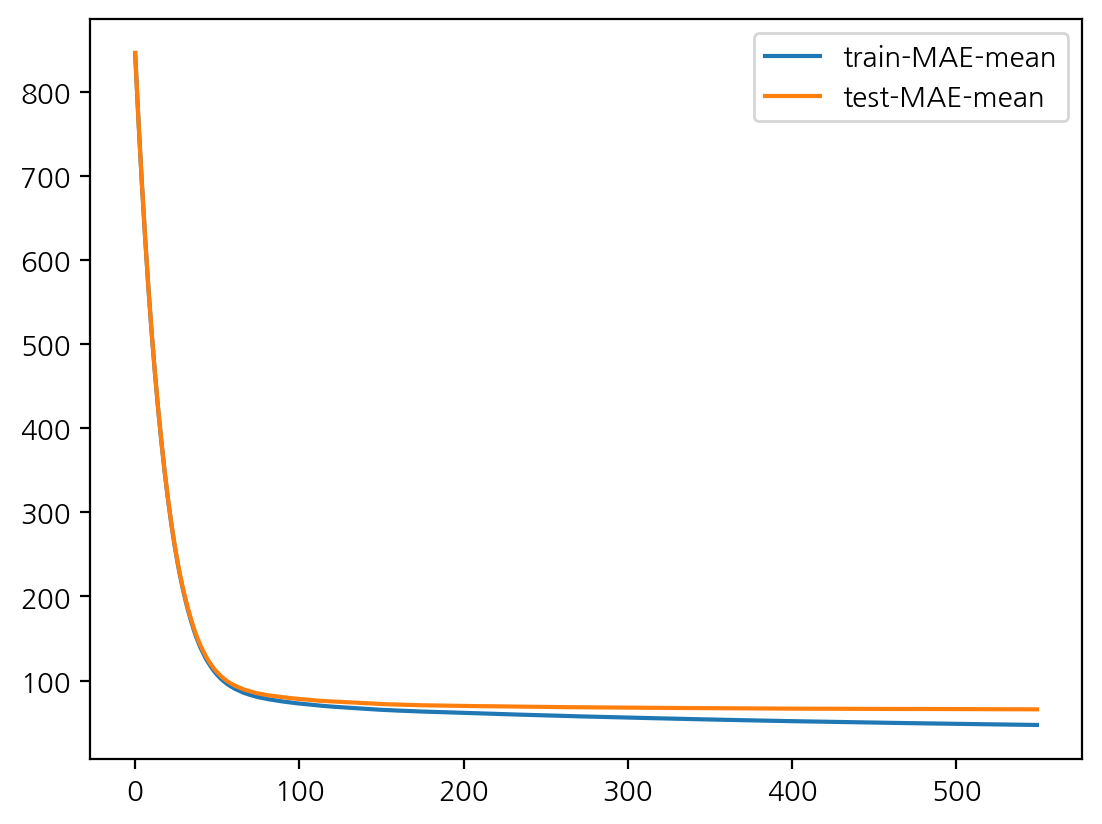

In [44]:
pd.DataFrame({
    'train-MAE-mean': df_lunch_result.loc['train-MAE-mean', 'cv_results'],
    'test-MAE-mean': df_lunch_result.loc['test-MAE-mean', 'cv_results']
}).plot();

## dinner model

In [45]:
dinner_model = catboost.CatBoostRegressor(
    eval_metric='MAE',
    random_state=42,
    logging_level='Silent',
    early_stopping_rounds=200
)

In [46]:
dinner_result = dinner_model.grid_search(
    param_grid=param_grid,
    X=X_train_d,
    y=y_train_d,
    cv=10
)
dinner_result

0:	loss: 74.1532380	best: 74.1532380 (0)	total: 315ms	remaining: 28m 2s
1:	loss: 54.1167235	best: 54.1167235 (1)	total: 586ms	remaining: 26m 6s
2:	loss: 51.8165987	best: 51.8165987 (2)	total: 857ms	remaining: 25m 25s
3:	loss: 50.1120501	best: 50.1120501 (3)	total: 1.05s	remaining: 23m 27s
4:	loss: 48.2430592	best: 48.2430592 (4)	total: 1.27s	remaining: 22m 34s
5:	loss: 47.5446849	best: 47.5446849 (5)	total: 1.43s	remaining: 21m 10s
6:	loss: 47.0824716	best: 47.0824716 (6)	total: 1.61s	remaining: 20m 31s
7:	loss: 46.5535820	best: 46.5535820 (7)	total: 1.8s	remaining: 20m 2s
8:	loss: 46.5492711	best: 46.5492711 (8)	total: 1.97s	remaining: 19m 29s
9:	loss: 46.0878855	best: 46.0878855 (9)	total: 2.16s	remaining: 19m 10s
10:	loss: 46.6317136	best: 46.0878855 (9)	total: 2.35s	remaining: 18m 57s
11:	loss: 46.2884048	best: 46.0878855 (9)	total: 2.53s	remaining: 18m 44s
12:	loss: 47.0152874	best: 46.0878855 (9)	total: 2.71s	remaining: 18m 33s
13:	loss: 46.9288290	best: 46.0878855 (9)	total: 2.8

112:	loss: 46.9178798	best: 45.5677902 (26)	total: 24.5s	remaining: 18m 53s
113:	loss: 47.4250091	best: 45.5677902 (26)	total: 24.7s	remaining: 18m 52s
114:	loss: 47.3982648	best: 45.5677902 (26)	total: 25s	remaining: 18m 55s
115:	loss: 46.6056531	best: 45.5677902 (26)	total: 25.2s	remaining: 18m 56s
116:	loss: 47.2653190	best: 45.5677902 (26)	total: 25.4s	remaining: 18m 56s
117:	loss: 47.7681879	best: 45.5677902 (26)	total: 25.7s	remaining: 18m 56s
118:	loss: 47.8170048	best: 45.5677902 (26)	total: 25.8s	remaining: 18m 55s
119:	loss: 47.8005250	best: 45.5677902 (26)	total: 26s	remaining: 18m 53s
120:	loss: 46.3411690	best: 45.5677902 (26)	total: 26.2s	remaining: 18m 53s
121:	loss: 48.0281200	best: 45.5677902 (26)	total: 26.5s	remaining: 18m 53s
122:	loss: 46.6761217	best: 45.5677902 (26)	total: 26.7s	remaining: 18m 54s
123:	loss: 47.0255354	best: 45.5677902 (26)	total: 26.9s	remaining: 18m 54s
124:	loss: 46.8310003	best: 45.5677902 (26)	total: 27.1s	remaining: 18m 52s
125:	loss: 45.56

221:	loss: 46.6761217	best: 45.5677902 (26)	total: 49.3s	remaining: 18m 56s
222:	loss: 47.0255354	best: 45.5677902 (26)	total: 49.5s	remaining: 18m 56s
223:	loss: 46.8310003	best: 45.5677902 (26)	total: 49.7s	remaining: 18m 55s
224:	loss: 45.5677902	best: 45.5677902 (26)	total: 49.9s	remaining: 18m 55s
225:	loss: 47.7200767	best: 45.5677902 (26)	total: 50.2s	remaining: 18m 57s
226:	loss: 47.8511926	best: 45.5677902 (26)	total: 50.4s	remaining: 18m 56s
227:	loss: 48.0959541	best: 45.5677902 (26)	total: 50.6s	remaining: 18m 56s
228:	loss: 47.6151589	best: 45.5677902 (26)	total: 50.8s	remaining: 18m 56s
229:	loss: 47.8999161	best: 45.5677902 (26)	total: 51.1s	remaining: 18m 55s
230:	loss: 48.1441677	best: 45.5677902 (26)	total: 51.3s	remaining: 18m 55s
231:	loss: 48.5776215	best: 45.5677902 (26)	total: 51.5s	remaining: 18m 54s
232:	loss: 46.9144688	best: 45.5677902 (26)	total: 51.7s	remaining: 18m 54s
233:	loss: 49.6963350	best: 45.5677902 (26)	total: 51.9s	remaining: 18m 53s
234:	loss: 4

330:	loss: 48.5776215	best: 45.5677902 (26)	total: 1m 14s	remaining: 18m 42s
331:	loss: 46.9144688	best: 45.5677902 (26)	total: 1m 14s	remaining: 18m 41s
332:	loss: 49.6963350	best: 45.5677902 (26)	total: 1m 14s	remaining: 18m 41s
333:	loss: 47.3703730	best: 45.5677902 (26)	total: 1m 14s	remaining: 18m 39s
334:	loss: 47.5532822	best: 45.5677902 (26)	total: 1m 14s	remaining: 18m 39s
335:	loss: 46.8829046	best: 45.5677902 (26)	total: 1m 15s	remaining: 18m 38s
336:	loss: 46.1725578	best: 45.5677902 (26)	total: 1m 15s	remaining: 18m 38s
337:	loss: 48.3494894	best: 45.5677902 (26)	total: 1m 15s	remaining: 18m 38s
338:	loss: 49.0375395	best: 45.5677902 (26)	total: 1m 15s	remaining: 18m 38s
339:	loss: 47.6926726	best: 45.5677902 (26)	total: 1m 16s	remaining: 18m 41s
340:	loss: 49.5924172	best: 45.5677902 (26)	total: 1m 16s	remaining: 18m 41s
341:	loss: 46.6583770	best: 45.5677902 (26)	total: 1m 16s	remaining: 18m 41s
342:	loss: 46.2738417	best: 45.5677902 (26)	total: 1m 17s	remaining: 18m 43s

438:	loss: 47.6926726	best: 45.5677902 (26)	total: 1m 42s	remaining: 19m 2s
439:	loss: 49.5924172	best: 45.5677902 (26)	total: 1m 42s	remaining: 19m 1s
440:	loss: 46.6583770	best: 45.5677902 (26)	total: 1m 42s	remaining: 19m 1s
441:	loss: 46.2738417	best: 45.5677902 (26)	total: 1m 42s	remaining: 19m 1s
442:	loss: 46.8530469	best: 45.5677902 (26)	total: 1m 43s	remaining: 19m
443:	loss: 47.3019812	best: 45.5677902 (26)	total: 1m 43s	remaining: 19m
444:	loss: 48.4862270	best: 45.5677902 (26)	total: 1m 43s	remaining: 19m
445:	loss: 47.4782579	best: 45.5677902 (26)	total: 1m 43s	remaining: 18m 59s
446:	loss: 47.3388733	best: 45.5677902 (26)	total: 1m 43s	remaining: 18m 59s
447:	loss: 50.0292560	best: 45.5677902 (26)	total: 1m 44s	remaining: 18m 59s
448:	loss: 49.2197474	best: 45.5677902 (26)	total: 1m 44s	remaining: 18m 58s
449:	loss: 48.5217814	best: 45.5677902 (26)	total: 1m 44s	remaining: 18m 58s
450:	loss: 49.2942069	best: 45.5677902 (26)	total: 1m 44s	remaining: 18m 57s
451:	loss: 47.6

547:	loss: 49.2197474	best: 45.5677902 (26)	total: 2m 10s	remaining: 19m 1s
548:	loss: 48.5217814	best: 45.5677902 (26)	total: 2m 10s	remaining: 19m 2s
549:	loss: 49.2942069	best: 45.5677902 (26)	total: 2m 11s	remaining: 19m 3s
550:	loss: 47.6414384	best: 45.5677902 (26)	total: 2m 11s	remaining: 19m 3s
551:	loss: 48.8057173	best: 45.5677902 (26)	total: 2m 11s	remaining: 19m 4s
552:	loss: 49.2560395	best: 45.5677902 (26)	total: 2m 12s	remaining: 19m 6s
553:	loss: 49.6458310	best: 45.5677902 (26)	total: 2m 12s	remaining: 19m 6s
554:	loss: 49.3320725	best: 45.5677902 (26)	total: 2m 12s	remaining: 19m 7s
555:	loss: 49.1930783	best: 45.5677902 (26)	total: 2m 13s	remaining: 19m 7s
556:	loss: 47.9119186	best: 45.5677902 (26)	total: 2m 13s	remaining: 19m 7s
557:	loss: 49.6971206	best: 45.5677902 (26)	total: 2m 13s	remaining: 19m 7s
558:	loss: 48.5087940	best: 45.5677902 (26)	total: 2m 13s	remaining: 19m 7s
559:	loss: 50.7759869	best: 45.5677902 (26)	total: 2m 14s	remaining: 19m 7s
560:	loss: 4

655:	loss: 47.9119186	best: 45.5677902 (26)	total: 2m 38s	remaining: 18m 55s
656:	loss: 49.6971206	best: 45.5677902 (26)	total: 2m 39s	remaining: 18m 55s
657:	loss: 48.5087940	best: 45.5677902 (26)	total: 2m 39s	remaining: 18m 54s
658:	loss: 50.7759869	best: 45.5677902 (26)	total: 2m 39s	remaining: 18m 54s
659:	loss: 48.8112912	best: 45.5677902 (26)	total: 2m 39s	remaining: 18m 54s
660:	loss: 49.9638231	best: 45.5677902 (26)	total: 2m 39s	remaining: 18m 53s
661:	loss: 52.0710983	best: 45.5677902 (26)	total: 2m 40s	remaining: 18m 52s
662:	loss: 52.6319660	best: 45.5677902 (26)	total: 2m 40s	remaining: 18m 51s
663:	loss: 51.5700731	best: 45.5677902 (26)	total: 2m 40s	remaining: 18m 50s
664:	loss: 53.2409647	best: 45.5677902 (26)	total: 2m 40s	remaining: 18m 50s
665:	loss: 49.2675876	best: 45.5677902 (26)	total: 2m 40s	remaining: 18m 49s
666:	loss: 50.2267636	best: 45.5677902 (26)	total: 2m 40s	remaining: 18m 49s
667:	loss: 52.9767059	best: 45.5677902 (26)	total: 2m 41s	remaining: 18m 48s

762:	loss: 51.5700731	best: 45.5677902 (26)	total: 3m 5s	remaining: 18m 36s
763:	loss: 53.2409647	best: 45.5677902 (26)	total: 3m 5s	remaining: 18m 35s
764:	loss: 49.2675876	best: 45.5677902 (26)	total: 3m 6s	remaining: 18m 34s
765:	loss: 50.2267636	best: 45.5677902 (26)	total: 3m 6s	remaining: 18m 34s
766:	loss: 52.9767059	best: 45.5677902 (26)	total: 3m 6s	remaining: 18m 34s
767:	loss: 50.7622236	best: 45.5677902 (26)	total: 3m 6s	remaining: 18m 33s
768:	loss: 49.7126228	best: 45.5677902 (26)	total: 3m 7s	remaining: 18m 33s
769:	loss: 49.9347856	best: 45.5677902 (26)	total: 3m 7s	remaining: 18m 32s
770:	loss: 48.0160801	best: 45.5677902 (26)	total: 3m 7s	remaining: 18m 31s
771:	loss: 49.9847970	best: 45.5677902 (26)	total: 3m 7s	remaining: 18m 31s
772:	loss: 50.3034975	best: 45.5677902 (26)	total: 3m 7s	remaining: 18m 30s
773:	loss: 51.2742130	best: 45.5677902 (26)	total: 3m 7s	remaining: 18m 30s
774:	loss: 50.1333717	best: 45.5677902 (26)	total: 3m 8s	remaining: 18m 29s
775:	loss: 4

870:	loss: 49.9847970	best: 45.5677902 (26)	total: 3m 32s	remaining: 18m 11s
871:	loss: 50.3034975	best: 45.5677902 (26)	total: 3m 32s	remaining: 18m 10s
872:	loss: 51.2742130	best: 45.5677902 (26)	total: 3m 32s	remaining: 18m 9s
873:	loss: 50.1333717	best: 45.5677902 (26)	total: 3m 32s	remaining: 18m 9s
874:	loss: 48.5395590	best: 45.5677902 (26)	total: 3m 33s	remaining: 18m 8s
875:	loss: 52.2238686	best: 45.5677902 (26)	total: 3m 33s	remaining: 18m 8s
876:	loss: 50.1172172	best: 45.5677902 (26)	total: 3m 33s	remaining: 18m 7s
877:	loss: 52.3945963	best: 45.5677902 (26)	total: 3m 33s	remaining: 18m 7s
878:	loss: 52.0492063	best: 45.5677902 (26)	total: 3m 33s	remaining: 18m 6s
879:	loss: 53.1651869	best: 45.5677902 (26)	total: 3m 33s	remaining: 18m 5s
880:	loss: 53.5546003	best: 45.5677902 (26)	total: 3m 34s	remaining: 18m 5s
881:	loss: 50.3953726	best: 45.5677902 (26)	total: 3m 34s	remaining: 18m 4s
882:	loss: 48.9228311	best: 45.5677902 (26)	total: 3m 34s	remaining: 18m 3s
883:	loss:

978:	loss: 53.1651869	best: 45.5677902 (26)	total: 4m	remaining: 17m 50s
979:	loss: 53.5546003	best: 45.5677902 (26)	total: 4m	remaining: 17m 50s
980:	loss: 50.3953726	best: 45.5677902 (26)	total: 4m	remaining: 17m 50s
981:	loss: 48.9228311	best: 45.5677902 (26)	total: 4m	remaining: 17m 50s
982:	loss: 52.8458943	best: 45.5677902 (26)	total: 4m 1s	remaining: 17m 49s
983:	loss: 50.6308145	best: 45.5677902 (26)	total: 4m 1s	remaining: 17m 49s
984:	loss: 52.5754659	best: 45.5677902 (26)	total: 4m 1s	remaining: 17m 49s
985:	loss: 56.5623050	best: 45.5677902 (26)	total: 4m 1s	remaining: 17m 49s
986:	loss: 56.5883244	best: 45.5677902 (26)	total: 4m 2s	remaining: 17m 48s
987:	loss: 54.2569279	best: 45.5677902 (26)	total: 4m 2s	remaining: 17m 48s
988:	loss: 54.5030075	best: 45.5677902 (26)	total: 4m 2s	remaining: 17m 48s
989:	loss: 53.4579753	best: 45.5677902 (26)	total: 4m 2s	remaining: 17m 48s
990:	loss: 55.2632197	best: 45.5677902 (26)	total: 4m 3s	remaining: 17m 48s
991:	loss: 50.2812731	be

1085:	loss: 56.5883244	best: 45.5677902 (26)	total: 4m 30s	remaining: 17m 41s
1086:	loss: 54.2569279	best: 45.5677902 (26)	total: 4m 30s	remaining: 17m 41s
1087:	loss: 54.5030075	best: 45.5677902 (26)	total: 4m 31s	remaining: 17m 40s
1088:	loss: 53.4579753	best: 45.5677902 (26)	total: 4m 31s	remaining: 17m 40s
1089:	loss: 54.7337187	best: 45.5677902 (26)	total: 4m 31s	remaining: 17m 40s
1090:	loss: 50.0691016	best: 45.5677902 (26)	total: 4m 31s	remaining: 17m 40s
1091:	loss: 47.4529092	best: 45.5677902 (26)	total: 4m 32s	remaining: 17m 41s
1092:	loss: 46.3253617	best: 45.5677902 (26)	total: 4m 32s	remaining: 17m 42s
1093:	loss: 46.0384521	best: 45.5677902 (26)	total: 4m 33s	remaining: 17m 43s
1094:	loss: 46.0082358	best: 45.5677902 (26)	total: 4m 34s	remaining: 17m 44s
1095:	loss: 46.4896012	best: 45.5677902 (26)	total: 4m 34s	remaining: 17m 45s
1096:	loss: 45.7526352	best: 45.5677902 (26)	total: 4m 35s	remaining: 17m 46s
1097:	loss: 46.1100053	best: 45.5677902 (26)	total: 4m 35s	remai

1191:	loss: 46.1838691	best: 45.5677902 (26)	total: 4m 59s	remaining: 17m 23s
1192:	loss: 46.0314029	best: 45.5677902 (26)	total: 4m 59s	remaining: 17m 23s
1193:	loss: 46.0082358	best: 45.5677902 (26)	total: 5m	remaining: 17m 23s
1194:	loss: 46.4896012	best: 45.5677902 (26)	total: 5m	remaining: 17m 23s
1195:	loss: 45.7526352	best: 45.5677902 (26)	total: 5m	remaining: 17m 24s
1196:	loss: 46.1100053	best: 45.5677902 (26)	total: 5m 1s	remaining: 17m 25s
1197:	loss: 45.7119903	best: 45.5677902 (26)	total: 5m 2s	remaining: 17m 25s
1198:	loss: 46.1326777	best: 45.5677902 (26)	total: 5m 2s	remaining: 17m 26s
1199:	loss: 46.0246089	best: 45.5677902 (26)	total: 5m 3s	remaining: 17m 27s
1200:	loss: 46.4376421	best: 45.5677902 (26)	total: 5m 3s	remaining: 17m 27s
1201:	loss: 46.5973494	best: 45.5677902 (26)	total: 5m 3s	remaining: 17m 28s
1202:	loss: 47.0943629	best: 45.5677902 (26)	total: 5m 4s	remaining: 17m 28s
1203:	loss: 47.3982648	best: 45.5677902 (26)	total: 5m 4s	remaining: 17m 28s
1204:	

1297:	loss: 46.1326777	best: 45.5677902 (26)	total: 5m 26s	remaining: 16m 59s
1298:	loss: 46.0246089	best: 45.5677902 (26)	total: 5m 27s	remaining: 16m 59s
1299:	loss: 46.4376421	best: 45.5677902 (26)	total: 5m 27s	remaining: 16m 59s
1300:	loss: 46.5973494	best: 45.5677902 (26)	total: 5m 28s	remaining: 16m 59s
1301:	loss: 47.0943629	best: 45.5677902 (26)	total: 5m 28s	remaining: 16m 59s
1302:	loss: 47.3982648	best: 45.5677902 (26)	total: 5m 28s	remaining: 16m 59s
1303:	loss: 46.6056531	best: 45.5677902 (26)	total: 5m 28s	remaining: 16m 59s
1304:	loss: 47.2653190	best: 45.5677902 (26)	total: 5m 29s	remaining: 16m 59s
1305:	loss: 47.5936944	best: 45.5677902 (26)	total: 5m 29s	remaining: 16m 59s
1306:	loss: 47.8170048	best: 45.5677902 (26)	total: 5m 29s	remaining: 16m 59s
1307:	loss: 47.8005250	best: 45.5677902 (26)	total: 5m 30s	remaining: 16m 58s
1308:	loss: 46.2486681	best: 45.5677902 (26)	total: 5m 30s	remaining: 16m 58s
1309:	loss: 48.0281200	best: 45.5677902 (26)	total: 5m 30s	remai

1403:	loss: 47.2653190	best: 45.5677902 (26)	total: 5m 56s	remaining: 16m 42s
1404:	loss: 47.5936944	best: 45.5677902 (26)	total: 5m 57s	remaining: 16m 42s
1405:	loss: 47.8170048	best: 45.5677902 (26)	total: 5m 57s	remaining: 16m 42s
1406:	loss: 47.8005250	best: 45.5677902 (26)	total: 5m 57s	remaining: 16m 42s
1407:	loss: 46.2486681	best: 45.5677902 (26)	total: 5m 58s	remaining: 16m 42s
1408:	loss: 48.0281200	best: 45.5677902 (26)	total: 5m 58s	remaining: 16m 42s
1409:	loss: 46.6761217	best: 45.5677902 (26)	total: 5m 58s	remaining: 16m 41s
1410:	loss: 47.0255354	best: 45.5677902 (26)	total: 5m 59s	remaining: 16m 41s
1411:	loss: 46.3603904	best: 45.5677902 (26)	total: 5m 59s	remaining: 16m 41s
1412:	loss: 45.5677902	best: 45.5677902 (26)	total: 5m 59s	remaining: 16m 41s
1413:	loss: 47.7200767	best: 45.5677902 (26)	total: 6m	remaining: 16m 41s
1414:	loss: 47.8511926	best: 45.5677902 (26)	total: 6m	remaining: 16m 41s
1415:	loss: 48.0959541	best: 45.5677902 (26)	total: 6m	remaining: 16m 40

1509:	loss: 47.0255354	best: 45.5677902 (26)	total: 6m 23s	remaining: 16m 15s
1510:	loss: 46.3603904	best: 45.5677902 (26)	total: 6m 24s	remaining: 16m 15s
1511:	loss: 45.5677902	best: 45.5677902 (26)	total: 6m 24s	remaining: 16m 15s
1512:	loss: 47.7200767	best: 45.5677902 (26)	total: 6m 24s	remaining: 16m 15s
1513:	loss: 47.8511926	best: 45.5677902 (26)	total: 6m 25s	remaining: 16m 14s
1514:	loss: 48.0959541	best: 45.5677902 (26)	total: 6m 25s	remaining: 16m 14s
1515:	loss: 47.6151589	best: 45.5677902 (26)	total: 6m 25s	remaining: 16m 14s
1516:	loss: 47.8999161	best: 45.5677902 (26)	total: 6m 25s	remaining: 16m 13s
1517:	loss: 48.1441677	best: 45.5677902 (26)	total: 6m 26s	remaining: 16m 13s
1518:	loss: 48.5776215	best: 45.5677902 (26)	total: 6m 26s	remaining: 16m 13s
1519:	loss: 46.9144688	best: 45.5677902 (26)	total: 6m 26s	remaining: 16m 13s
1520:	loss: 49.6963350	best: 45.5677902 (26)	total: 6m 27s	remaining: 16m 13s
1521:	loss: 47.3703730	best: 45.5677902 (26)	total: 6m 27s	remai

1615:	loss: 47.8999161	best: 45.5677902 (26)	total: 6m 52s	remaining: 15m 53s
1616:	loss: 48.1441677	best: 45.5677902 (26)	total: 6m 53s	remaining: 15m 52s
1617:	loss: 48.5776215	best: 45.5677902 (26)	total: 6m 53s	remaining: 15m 52s
1618:	loss: 46.9144688	best: 45.5677902 (26)	total: 6m 53s	remaining: 15m 52s
1619:	loss: 49.6963350	best: 45.5677902 (26)	total: 6m 53s	remaining: 15m 52s
1620:	loss: 47.3703730	best: 45.5677902 (26)	total: 6m 54s	remaining: 15m 51s


KeyboardInterrupt: 

In [48]:
dinner_model.get_all_params()

In [ ]:
dinner_model.feature_names_

In [ ]:
dinner_model.feature_importances_

In [ ]:
pd.DataFrame(
    dinner_model.feature_importances_, index=dinner_model.feature_names_
).sort_values(0).plot.barh()

In [ ]:
df_dinner_result = pd.DataFrame(dinner_result)
df_dinner_result

In [ ]:
pd.DataFrame({
    'train-MAE-mean': df_dinner_result.loc['train-MAE-mean', 'cv_results'],
    'test-MAE-mean': df_dinner_result.loc['test-MAE-mean', 'cv_results']
}).plot();

## 테스트 데이터 학습

In [ ]:
lunch_model.fit(X_train_l, y_train_l)

In [ ]:
dinner_model.fit(X_train_d, y_train_d)

## 테스트 데이터 학습 검증

In [ ]:
lunch_test_pred = lunch_model.predict(X_test_l)

In [ ]:
dinner_test_pred = dinner_model.predict(X_test_d)

In [ ]:
lunch_test_mae = mean_absolute_error(lunch_test_pred, y_test_l)
lunch_test_mae

In [ ]:
dinner_test_mae = mean_absolute_error(dinner_test_pred, y_test_d)
dinner_test_mae

## 예측

In [ ]:
lunch_pred = lunch_model.predict(F_test_lunch)
lunch_pred[:5]

In [ ]:
len(lunch_pred)

In [ ]:
round_lunch_pred = lunch_pred.round()
round_lunch_pred[:5]

In [ ]:
dinner_pred = dinner_model.predict(F_test_dinner)
dinner_pred[:5]

In [ ]:
dinner_pred

In [ ]:
round_dinner_pred = dinner_pred.round()
round_dinner_pred[:5]

## 제출

In [ ]:
# 답지 확인
submission.head()

In [ ]:
# 예측한 값을 답안지에 옮겨 적습니다.
submission['중식계'] = round_lunch_pred
submission['석식계'] = round_dinner_pred
submission.head(3)

In [ ]:
# test 데이터로 구한 실제 점수를 비교해 보기 위해 제출 시 점수를 함께 적으면 비교하기 좋습니다.
file_name = f"data/구내식당/submit_최종_Cat_L:{lunch_test_mae:.5f}, D:{dinner_test_mae:.5f}.csv"
file_name

In [ ]:
# 제출하기 위해 csv 파일로 저장합니다.
submission.to_csv(file_name, index=False)

In [ ]:
# 파일 저장이 제대로 되었는지 확인합니다.
pd.read_csv(file_name)